In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import font_manager, rc # 폰트 설정과 한글깨짐 방기
font_path = "C:/Windows/Fonts/NGULIM.TTF"
font = font_manager.FontProperties(fname=font_path).get_name()
rc('font', family=font)
import seaborn as sns
import os
from tqdm.autonotebook import tqdm # loop의 진행상황을 시각적으로 표현하기 위한 라이브러리

from itertools import product # 효율적으로 loop를 생성하기 위한 라이브러리

from tslearn.clustering import TimeSeriesKMeans # TimeSeriesKMeans 클러스터링 import

from sklearn.preprocessing import StandardScaler # 데이터 정규화에 사용할 StandardScaler import
from sklearn.metrics import silhouette_score # 성능 지표를 계산하기 위해 silhouette_score import
from sklearn.cluster import DBSCAN # DBSCAN 클러스터링 import

sns.set_style("darkgrid")

SEED=23

C:\Users\User\anaconda3\envs\MRI_py38\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\User\anaconda3\envs\MRI_py38\lib\site-packages\numpy\.libs\libopenblas.PYQHXLVVQ7VESDPUVUADXEVJOBGHJPAY.gfortran-win_amd64.dll
C:\Users\User\anaconda3\envs\MRI_py38\lib\site-packages\numpy\.libs\libopenblas.WCDJNK7YVMPZQ2ME2ZZHJJRJ3JIKNDB7.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:\n%s" %
C:\Users\User\AppData\Local\Temp/ipykernel_2288/1464652243.py:11: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
# 경고 메세지 off
import warnings
warnings.filterwarnings(action='ignore')

In [3]:
# Data load
address = 'data_processing/Dataset'
data = pd.read_csv(os.path.join(address,'df_pm10_7day_result_1110.csv'), header = 0, encoding='cp949')
data.head()


in_serial         in_id             time_day  in_pm10_day
0       요양원  ICL1L2000011  2020-07-22 00:00:00         21.5
1       요양원  ICL1L2000011  2020-07-22 00:10:00         22.3
2       요양원  ICL1L2000011  2020-07-22 00:20:00         21.8
3       요양원  ICL1L2000011  2020-07-22 00:30:00         21.5
4       요양원  ICL1L2000011  2020-07-22 00:40:00         21.5

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 153211 entries, 0 to 153210
Data columns (total 4 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   in_serial    153211 non-null  object 
 1   in_id        153211 non-null  object 
 2   time_day     153211 non-null  object 
 3   in_pm10_day  152785 non-null  float64
dtypes: float64(1), object(3)
memory usage: 4.7+ MB


In [5]:
# in_serial = 장소 정보와 in_id =data sample id만 data_cd로 생성
data_cd = data[['in_serial','in_id']]
data_cd = data_cd.drop_duplicates()
data_cd = data_cd.set_index(keys='in_id')

In [6]:
data_cd

in_serial
in_id                 
ICL1L2000011       요양원
ICL1L2000017       요양원
ICL1L2000064      체육시설
ICL1L2000065      체육시설
ICL1L2000234       경로당
...                ...
IS70W2000853       요양원
IS70W2000854       요양원
IS70W2000855       요양원
IS70W2000856       요양원
IS70W2000858       요양원

[152 rows x 1 columns]

In [7]:
print(data['in_id'].unique(), len(data['in_id'].unique()))

['ICL1L2000011' 'ICL1L2000017' 'ICL1L2000064' 'ICL1L2000065'
 'ICL1L2000234' 'ICL1L2000235' 'ICL1L2000236' 'ICL1L2000237'
 'ICL1L2000238' 'ICL1L2000239' 'ICL1L2000240' 'ICL1L2000241'
 'ICL1L2000242' 'ICL1L2000244' 'ICL1L2000245' 'ICL1L2000246'
 'ICL1L2000247' 'ICL1L2000248' 'ICL1L2000249' 'ICL1L2000252'
 'ICL1L2000253' 'ICL1L2000254' 'ICL1L2000255' 'ICL1L2000257'
 'ICL1L2000258' 'ICL1L2000259' 'ICL1L2000260' 'ICL1L2000262'
 'ICL1L2000263' 'ICL1L2000265' 'ICL1L2000266' 'ICL1L2000267'
 'ICL1L2000268' 'ICL1L2000269' 'ICL1L2000271' 'ICL1L2000272'
 'ICL1L2000274' 'ICL1L2000275' 'ICL1L2000276' 'ICL1L2000277'
 'ICL1L2000278' 'ICL1L2000279' 'ICL1L2000280' 'ICL1L2000281'
 'ICL1L2000283' 'ICW0W2000011' 'ICW0W2000012' 'ICW0W2000013'
 'ICW0W2000014' 'ICW0W2000015' 'ICW0W2000016' 'ICW0W2000018'
 'ICW0W2000019' 'ICW0W2000020' 'ICW0W2000022' 'ICW0W2000023'
 'ICW0W2000024' 'ICW0W2000025' 'ICW0W2000031' 'ICW0W2000032'
 'ICW0W2000033' 'ICW0W2000034' 'ICW0W2000087' 'ICW0W2000088'
 'ICW0W2000089' 'ICW0W20

In [8]:
# 클러스터링을 진행하기 위해 data table 형태 변환
df_pivot = pd.DataFrame()
for in_data_cd in data['in_id'].unique():
    
    sample = data[data['in_id'] == in_data_cd]
    time_index = []
    for i in range(0,len(sample)):
        time_index.append(i)
    sample['time_index'] = time_index
    df_pivot = pd.concat([df_pivot,sample], ignore_index=True)

In [9]:
df_pivot= df_pivot.pivot_table(index="time_index",
                       columns="in_id",
                       values="in_pm10_day")

In [10]:
df_pivot

in_id       ICL1L2000011  ICL1L2000017  ICL1L2000064  ICL1L2000065  \
time_index                                                           
0                   21.5          11.4          15.3          16.2   
1                   22.3          11.3          15.2          16.2   
2                   21.8          11.3          16.1          16.6   
3                   21.5          11.5          14.5          16.7   
4                   21.5          11.1          16.9          16.9   
...                  ...           ...           ...           ...   
1003                 3.8           3.3          19.3          13.8   
1004                 4.0           3.6          19.8          14.0   
1005                 3.9           4.1          21.8          14.7   
1006                 4.1           5.5          20.7          14.2   
1007                 4.3           7.2          21.7          14.8   

in_id       ICL1L2000234  ICL1L2000235  ICL1L2000236  ICL1L2000237  \
time_index                                                           
0                   43.3          29.1          18.6          23.5   
1                   43.5          28.8          18.5          23.3   
2                   42.5          27.8          18.6          23.7   
3                   41.9          27.0          19.0          23.6   
4                   42.2          27.5          18.5          23.8   
...                  ...           ...           ...           ...   
1003                37.1          10.8          38.4           0.0   
1004                37.5          10.8          39.0           0.2   
1005                37.1          10.0          39.7           0.2   
1006                37.5           9.5          40.3           0.3   
1007                37.0           9.8          40.0           0.4   

in_id       ICL1L2000238  ICL1L2000239  ...  ICW0W2100277  ICW0W2100278  \
time_index                              ...                               
0                   61.0          52.7  ...           3.0           3.2   
1                   60.9          52.5  ...           3.2           3.8   
2                   60.6          52.5  ...           3.4           3.3   
3                   60.4          52.6  ...           3.4           3.7   
4                   60.2          52.0  ...           3.6           3.8   
...                  ...           ...  ...           ...           ...   
1003                13.6          42.3  ...          11.2          10.9   
1004                14.6          42.5  ...          11.0          11.0   
1005                14.9          43.2  ...          11.1          11.1   
1006                17.2          45.6  ...          11.1          10.9   
1007                18.6          46.5  ...          11.0          10.9   

in_id       IS70W2000822  IS70W2000851  IS70W2000852  IS70W2000853  \
time_index                                                           
0                  98.97           9.9           5.0           5.9   
1                  98.94           8.5           5.0           6.2   
2                  98.76           8.2           4.4           6.0   
3                  98.42           8.2           4.5           5.6   
4                  98.59           6.9           5.4           5.6   
...                  ...           ...           ...           ...   
1003               98.03           3.0           5.0           5.9   
1004               98.00           2.6           5.0           6.4   
1005               98.18           2.2           5.6           7.2   
1006               98.09           2.3           5.7           6.1   
1007               98.18           2.4           5.7           6.5   

in_id       IS70W2000854  IS70W2000855  IS70W2000856  IS70W2000858  
time_index                                                          
0                    0.7           8.7          14.1          12.6  
1                    1.0           9.5          14.6          12.2  
2              

#  1일 데이터로 자르기

In [11]:
# 1일 데이터 = df_pivot2
df_pivot_1day = df_pivot.loc[:143]
df_pivot_1day

in_id       ICL1L2000011  ICL1L2000017  ICL1L2000064  ICL1L2000065  \
time_index                                                           
0                   21.5          11.4          15.3          16.2   
1                   22.3          11.3          15.2          16.2   
2                   21.8          11.3          16.1          16.6   
3                   21.5          11.5          14.5          16.7   
4                   21.5          11.1          16.9          16.9   
...                  ...           ...           ...           ...   
139                 40.0          13.4          41.7          16.7   
140                 39.2          13.4          41.1          16.9   
141                 45.4          13.1          40.5          17.0   
142                 44.3          13.3          41.3          16.3   
143                 43.1          14.8          42.2          15.8   

in_id       ICL1L2000234  ICL1L2000235  ICL1L2000236  ICL1L2000237  \
time_index                                                           
0                   43.3          29.1          18.6          23.5   
1                   43.5          28.8          18.5          23.3   
2                   42.5          27.8          18.6          23.7   
3                   41.9          27.0          19.0          23.6   
4                   42.2          27.5          18.5          23.8   
...                  ...           ...           ...           ...   
139                 23.5           3.0          58.9          19.1   
140                 23.7           2.8          57.8          19.6   
141                 23.0           2.7          57.5          19.4   
142                 22.0           2.4          56.3          19.4   
143                 22.0           2.4          57.5          19.1   

in_id       ICL1L2000238  ICL1L2000239  ...  ICW0W2100277  ICW0W2100278  \
time_index                              ...                               
0                   61.0          52.7  ...           3.0           3.2   
1                   60.9          52.5  ...           3.2           3.8   
2                   60.6          52.5  ...           3.4           3.3   
3                   60.4          52.6  ...           3.4           3.7   
4                   60.2          52.0  ...           3.6           3.8   
...                  ...           ...  ...           ...           ...   
139                 64.7          24.0  ...           8.7           7.5   
140                 65.3          22.3  ...           8.1           7.8   
141                 65.0          22.0  ...           8.6           7.1   
142                 67.2          21.9  ...           7.9           6.9   
143                 65.4          20.7  ...           7.5           6.9   

in_id       IS70W2000822  IS70W2000851  IS70W2000852  IS70W2000853  \
time_index                                                           
0                  98.97           9.9           5.0           5.9   
1                  98.94           8.5           5.0           6.2   
2                  98.76           8.2           4.4           6.0   
3                  98.42           8.2           4.5           5.6   
4                  98.59           6.9           5.4           5.6   
...                  ...           ...           ...           ...   
139                96.94           2.0           3.0           1.3   
140                96.91           1.8           3.0           1.6   
141                97.21           2.2           2.4           2.0   
142                97.28           2.3           2.9           2.2   
143                97.33           1.9           2.2           1.5   

in_id       IS70W2000854  IS70W2000855  IS70W2000856  IS70W2000858  
time_index                                                          
0                    0.7           8.7          14.1          12.6  
1                    1.0           9.5          14.6          12.2  
2              

In [12]:
x = df_pivot_1day[['ICL1L2000237', 'ICW0W2000016']]
x.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 144 entries, 0 to 143
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   ICL1L2000237  144 non-null    float64
 1   ICW0W2000016  144 non-null    float64
dtypes: float64(2)
memory usage: 3.4 KB


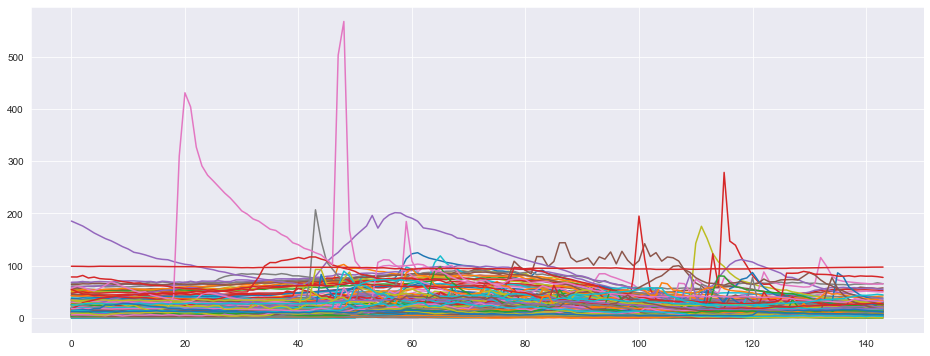

In [13]:
# df_pivot_1day 시각화
fig, ax = plt.subplots(figsize=(16, 6))
for col in df_pivot_1day.columns[1:]:
    df_pivot_1day[col] = df_pivot_1day[col].astype('float64')
    df_pivot_1day.plot(y=col, use_index=False, ax=ax,legend = False)
    #plt.savefig(address + '/images/all_day30.png')
plt.show()

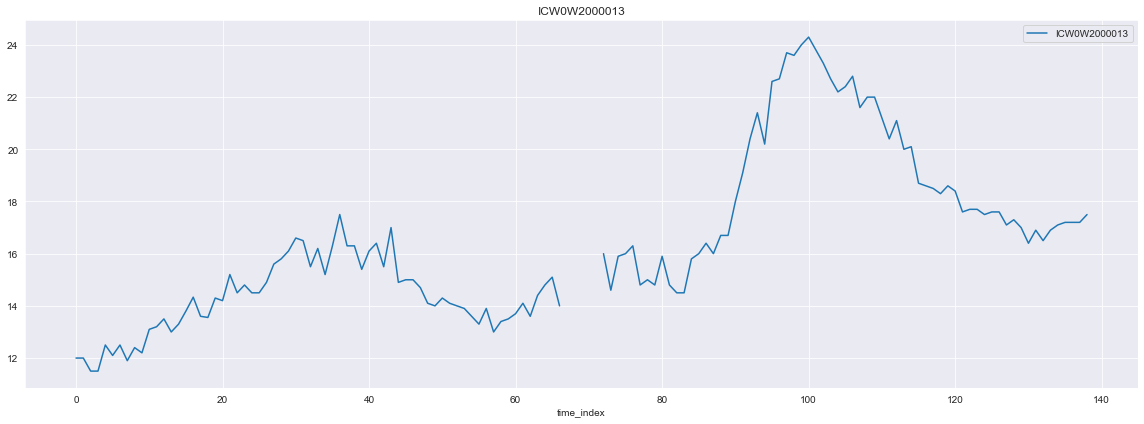

In [14]:
# ICW0W2000013 하나만 시각화한 결과
for col in df_pivot_1day[['ICW0W2000013']].columns:
    fig, ax = plt.subplots(figsize=(16, 6))
    df_pivot_1day.plot(y=col, use_index=True, ax=ax)
    ax.set_title(col)
plt.tight_layout()
plt.show()

In [15]:
# 데이터의 결측값 확인
x = df_pivot_1day[['ICW0W2000013', 'ICW0W2000016','ICW0W2000015']]
x.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 144 entries, 0 to 143
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   ICW0W2000013  134 non-null    float64
 1   ICW0W2000016  144 non-null    float64
 2   ICW0W2000015  144 non-null    float64
dtypes: float64(3)
memory usage: 4.5 KB


In [16]:
# 선형보간법 사용
df_pivot_int = df_pivot_1day.interpolate(method='linear')

In [17]:
df_pivot_int.index

Int64Index([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,
            ...
            134, 135, 136, 137, 138, 139, 140, 141, 142, 143],
           dtype='int64', name='time_index', length=144)

In [18]:
# 데이터 가장 앞 부분에 존재하는 결측값은 이전 값으로 대체함
df_pivot_int_test = df_pivot_int.reindex(df_pivot_int.index, method="ffill")

In [19]:
# 데이터 가장 끝부분에 존재하는 결측값은 이전 값으로 대체함
df_pivot_int_test = df_pivot_int.reindex(df_pivot_int.index, method="bfill")

In [20]:
x = df_pivot_int_test[['ICW0W2000013', 'ICW0W2000016','ICW0W2000015']]
x.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 144 entries, 0 to 143
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   ICW0W2000013  144 non-null    float64
 1   ICW0W2000016  144 non-null    float64
 2   ICW0W2000015  144 non-null    float64
dtypes: float64(3)
memory usage: 4.5 KB


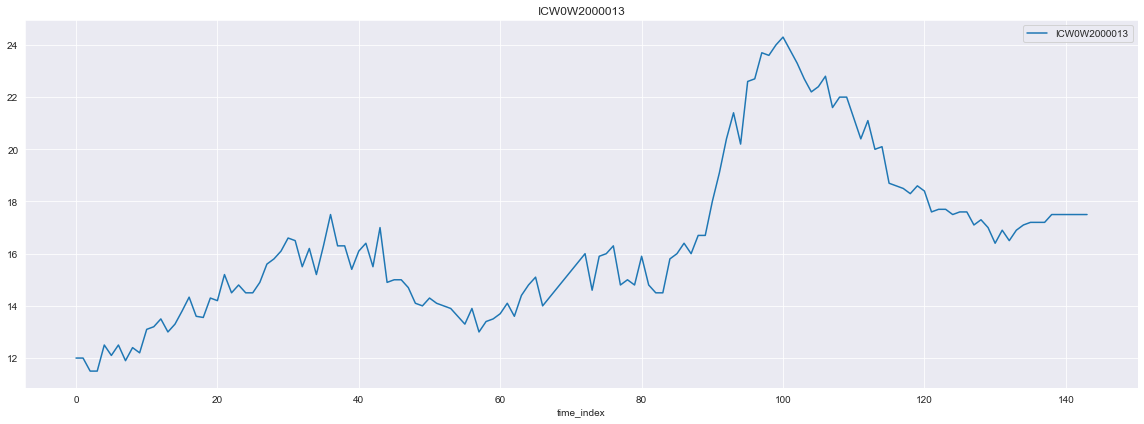

In [21]:
# 선형 보간 결과 시각화
for col in df_pivot_int_test[['ICW0W2000013']].columns:
    fig, ax = plt.subplots(figsize=(16, 6))
    df_pivot_int_test.plot(y=col, use_index=True, ax=ax)
    ax.set_title(col)
plt.tight_layout()
plt.show()

In [22]:
x = df_pivot_int_test[['ICW0W2000013', 'ICW0W2000016','ICW0W2000015']]
x.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 144 entries, 0 to 143
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   ICW0W2000013  144 non-null    float64
 1   ICW0W2000016  144 non-null    float64
 2   ICW0W2000015  144 non-null    float64
dtypes: float64(3)
memory usage: 4.5 KB


In [23]:
df_pivot_int_test.head()

in_id       ICL1L2000011  ICL1L2000017  ICL1L2000064  ICL1L2000065  \
time_index                                                           
0                   21.5          11.4          15.3          16.2   
1                   22.3          11.3          15.2          16.2   
2                   21.8          11.3          16.1          16.6   
3                   21.5          11.5          14.5          16.7   
4                   21.5          11.1          16.9          16.9   

in_id       ICL1L2000234  ICL1L2000235  ICL1L2000236  ICL1L2000237  \
time_index                                                           
0                   43.3          29.1          18.6          23.5   
1                   43.5          28.8          18.5          23.3   
2                   42.5          27.8          18.6          23.7   
3                   41.9          27.0          19.0          23.6   
4                   42.2          27.5          18.5          23.8   

in_id       ICL1L2000238  ICL1L2000239  ...  ICW0W2100277  ICW0W2100278  \
time_index                              ...                               
0                   61.0          52.7  ...           3.0           3.2   
1                   60.9          52.5  ...           3.2           3.8   
2                   60.6          52.5  ...           3.4           3.3   
3                   60.4          52.6  ...           3.4           3.7   
4                   60.2          52.0  ...           3.6           3.8   

in_id       IS70W2000822  IS70W2000851  IS70W2000852  IS70W2000853  \
time_index                                                           
0                  98.97           9.9           5.0           5.9   
1                  98.94           8.5           5.0           6.2   
2                  98.76           8.2           4.4           6.0   
3                  98.42           8.2           4.5           5.6   
4                  98.59           6.9           5.4           5.6   

in_id       IS70W2000854  IS70W2000855  IS70W2000856  IS70W2000858  
time_index                                                          
0                    0.7           8.7          14.1          12.6  
1                    1.0           9.5          14.6          12.2  
2                    0.7           8.9          13.8          12.3  
3                    0.8           9.0          13.1          12.2  
4                    0.7           6.9          11.7          12.4  

[5 rows x 152 columns]

In [24]:
series_df = df_pivot_int_test.T
series_df = series_df.dropna(axis='columns')
series_df.head()

time_index     0     1     2     3     4     5     6          7     8     9    \
in_id                                                                           
ICL1L2000011  21.5  22.3  21.8  21.5  21.5  21.1  20.3  21.777778  22.4  21.9   
ICL1L2000017  11.4  11.3  11.3  11.5  11.1  11.8  12.0  12.200000  12.4  13.1   
ICL1L2000064  15.3  15.2  16.1  14.5  16.9  15.3  15.5  15.500000  15.9  16.8   
ICL1L2000065  16.2  16.2  16.6  16.7  16.9  16.6  16.8  17.100000  17.3  17.3   
ICL1L2000234  43.3  43.5  42.5  41.9  42.2  41.8  42.8  42.800000  42.9  43.0   

time_index    ...   134   135   136   137   138   139   140   141   142   143  
in_id         ...                                                              
ICL1L2000011  ...  39.4  41.2  33.8  41.4  41.3  40.0  39.2  45.4  44.3  43.1  
ICL1L2000017  ...  11.7  12.5  12.6  12.8  12.9  13.4  13.4  13.1  13.3  14.8  
ICL1L2000064  ...  37.8  38.0  40.3  40.6  41.5  41.7  41.1  40.5  41.3  42.2  
ICL1L2000065  ...  17.8  17.1  17.7  16.2  16.4  16.7  16.9  17.0  16.3  15.8  
ICL1L2000234  ...  24.3  24.1  23.6  23.7  23.9  23.5  23.7  23.0  22.0  22.0  

[5 rows x 144 columns]

In [25]:
# Scaling
scaler = StandardScaler() # StandardScaler 정규화 객체 생성

scaled_ts = scaler.fit_transform(series_df.T).T # df_pivot에 대해 정규화를 진행함
scaled_ts_df = pd.DataFrame(scaled_ts)

In [26]:
scaled_ts_df.head()

0         1         2         3         4         5         6    \
0  0.281009  0.340373  0.303270  0.281009  0.281009  0.251327  0.191964   
1 -1.083745 -1.098993 -1.098993 -1.068497 -1.129489 -1.022753 -0.992257   
2 -1.486973 -1.502893 -1.359613 -1.614333 -1.232253 -1.486973 -1.455133   
3 -0.946086 -0.946086 -0.874621 -0.856754 -0.821022 -0.874621 -0.838888   
4  0.077846  0.091822  0.021944 -0.019982  0.000981 -0.026970  0.042908   

        7         8         9    ...       134       135       136       137  \
0  0.301621  0.347793  0.310691  ...  1.609268  1.742836  1.193723  1.757677   
1 -0.961761 -0.931265 -0.824529  ... -1.038001 -0.916017 -0.900769 -0.870273   
2 -1.455133 -1.391453 -1.248173  ...  2.095029  2.126869  2.493030  2.540790   
3 -0.785289 -0.749557 -0.749557  ... -0.660225 -0.785289 -0.678092 -0.946086   
4  0.042908  0.049895  0.056883  ... -1.249822 -1.263797 -1.298736 -1.291748   

        138       139       140       141       142       143  
0  1.750257  1.653791  1.594427  2.054495  1.972870  1.883825  
1 -0.855025 -0.778785 -0.778785 -0.824529 -0.794033 -0.565314  
2  2.684070  2.715910  2.620390  2.524870  2.652230  2.795510  
3 -0.910353 -0.856754 -0.821022 -0.803156 -0.928220 -1.017551  
4 -1.277773 -1.305724 -1.291748 -1.340662 -1.410539 -1.410539  

[5 rows x 144 columns]

In [27]:
namesofMySeries = []
for ind, i in enumerate(series_df.T):
    namesofMySeries.append(i)

In [28]:
print(namesofMySeries)
print(len(namesofMySeries))

['ICL1L2000011', 'ICL1L2000017', 'ICL1L2000064', 'ICL1L2000065', 'ICL1L2000234', 'ICL1L2000235', 'ICL1L2000236', 'ICL1L2000237', 'ICL1L2000238', 'ICL1L2000239', 'ICL1L2000240', 'ICL1L2000241', 'ICL1L2000242', 'ICL1L2000244', 'ICL1L2000245', 'ICL1L2000246', 'ICL1L2000247', 'ICL1L2000248', 'ICL1L2000249', 'ICL1L2000252', 'ICL1L2000253', 'ICL1L2000254', 'ICL1L2000255', 'ICL1L2000257', 'ICL1L2000258', 'ICL1L2000259', 'ICL1L2000260', 'ICL1L2000262', 'ICL1L2000263', 'ICL1L2000265', 'ICL1L2000266', 'ICL1L2000267', 'ICL1L2000268', 'ICL1L2000269', 'ICL1L2000271', 'ICL1L2000272', 'ICL1L2000274', 'ICL1L2000275', 'ICL1L2000276', 'ICL1L2000277', 'ICL1L2000278', 'ICL1L2000279', 'ICL1L2000280', 'ICL1L2000281', 'ICL1L2000283', 'ICW0W2000011', 'ICW0W2000012', 'ICW0W2000013', 'ICW0W2000014', 'ICW0W2000015', 'ICW0W2000016', 'ICW0W2000018', 'ICW0W2000019', 'ICW0W2000020', 'ICW0W2000022', 'ICW0W2000023', 'ICW0W2000024', 'ICW0W2000025', 'ICW0W2000031', 'ICW0W2000032', 'ICW0W2000033', 'ICW0W2000034', 'ICW0W2

In [29]:
def get_kmeans_results(data, max_clusters=10, metric='euclidean', seed=23):
    """
    KMeans 실행 과 결과 시각화

    data: pd.DataFrame or np.array
        Time Series Data
    max_clusters: int
        Number of different clusters for KMeans algorithm
    metric: str
        Distance metric between the observations
    seed: int
        random seed
    Returns: 
    -------
    None      
    """
    # Main metrics
    distortions = []
    silhouette = []
    clusters_range = range(1, max_clusters+1)
    
    for K in tqdm(clusters_range):
        kmeans_model = TimeSeriesKMeans(n_clusters=K, metric=metric, n_jobs=-1, max_iter=10, random_state=seed)
        kmeans_model.fit(data)
        distortions.append(kmeans_model.inertia_)
        if K > 1:
            silhouette.append(silhouette_score(data, kmeans_model.labels_))
        
    # Visualization
    plt.figure(figsize=(10,4))
    plt.plot(clusters_range, distortions, 'bx-')
    plt.xlabel('k')
    plt.ylabel('Distortion')
    plt.title('Elbow Method')
    
    plt.figure(figsize=(10,4))
    plt.plot(clusters_range[1:], silhouette, 'bx-')
    plt.xlabel('k')
    plt.ylabel('Silhouette score')
    plt.title('Silhouette');

In [34]:
 def plot_cluster_ts(current_cluster):
    """
    시계열 클러스터 결과 선 그래프로 시각화

    current_cluster: np.array
        Cluster with time series 
    Returns:
    -------
    None 
    """
    Cluster_idx=[]
    fig, ax = plt.subplots(
        int(np.ceil(current_cluster.shape[0]/4)),4,
        figsize=(45, 3*int(np.ceil(current_cluster.shape[0]/4)))
    )
    fig.autofmt_xdate(rotation=45)
    ax = ax.reshape(-1)
    for i in range(len(current_cluster)):
        ax[i].plot(current_cluster.iloc[i,:])
        plt.xticks(rotation=45)
        Cluster_idx.append(current_cluster.index[i])
        
    plt.tight_layout()
    plt.show()
    print(Cluster_idx);

  0%|          | 0/10 [00:00<?, ?it/s]

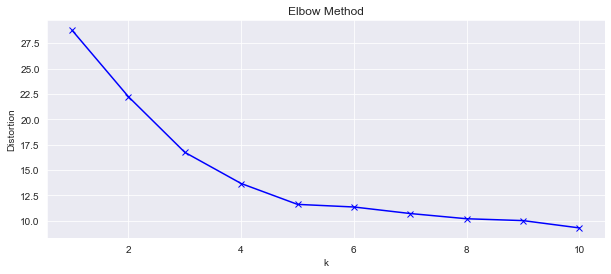

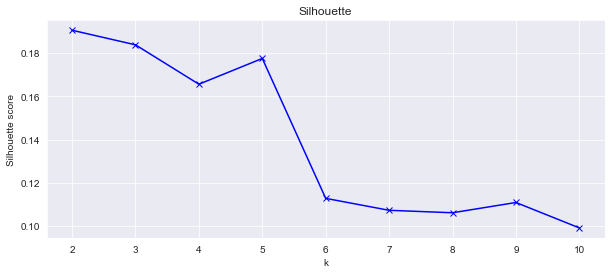

In [30]:
# DTW algorithm을 사용하여 TimeSeriesKMeans 진행
get_kmeans_results(data=scaled_ts_df, max_clusters=10, metric='dtw', seed=SEED)

In [32]:
# in_id의 군집결과 조회
cluster_model = TimeSeriesKMeans(n_clusters=5, metric='dtw', n_jobs=-1, max_iter=10, random_state=SEED) # k를 5로 설정하여 결과 조회함
cluster_labels = cluster_model.fit_predict(scaled_ts_df)
fancy_names_for_labels = [f"Cluster {label}" for label in cluster_labels]
result = pd.DataFrame(zip(namesofMySeries,fancy_names_for_labels),columns=["Series","Cluster"]).sort_values(by="Cluster").set_index("Series")

ts_clustered = [scaled_ts_df.iloc[(cluster_labels == lable), :] for lable in np.unique(cluster_labels)]

result

Cluster
Series                 
ICW0W2000648  Cluster 0
ICW0W2000821  Cluster 0
ICW0W2000033  Cluster 0
ICW0W2000822  Cluster 0
ICW0W2000827  Cluster 0
...                 ...
ICW0W2000792  Cluster 4
ICW0W2000788  Cluster 4
ICW0W2000783  Cluster 4
ICW0W2000850  Cluster 4
ICW0W2000833  Cluster 4

[152 rows x 1 columns]

In [36]:
# 군집별 data sample 수 조회
merge_outer = pd.merge(result,data_cd, how='outer', left_index=True, right_index=True)
result_cnt = merge_outer.groupby('Cluster').count().reset_index()
result_cnt

Cluster  in_serial
0  Cluster 0         37
1  Cluster 1         48
2  Cluster 2         22
3  Cluster 3         22
4  Cluster 4         23

==========Cluster number: 0==========


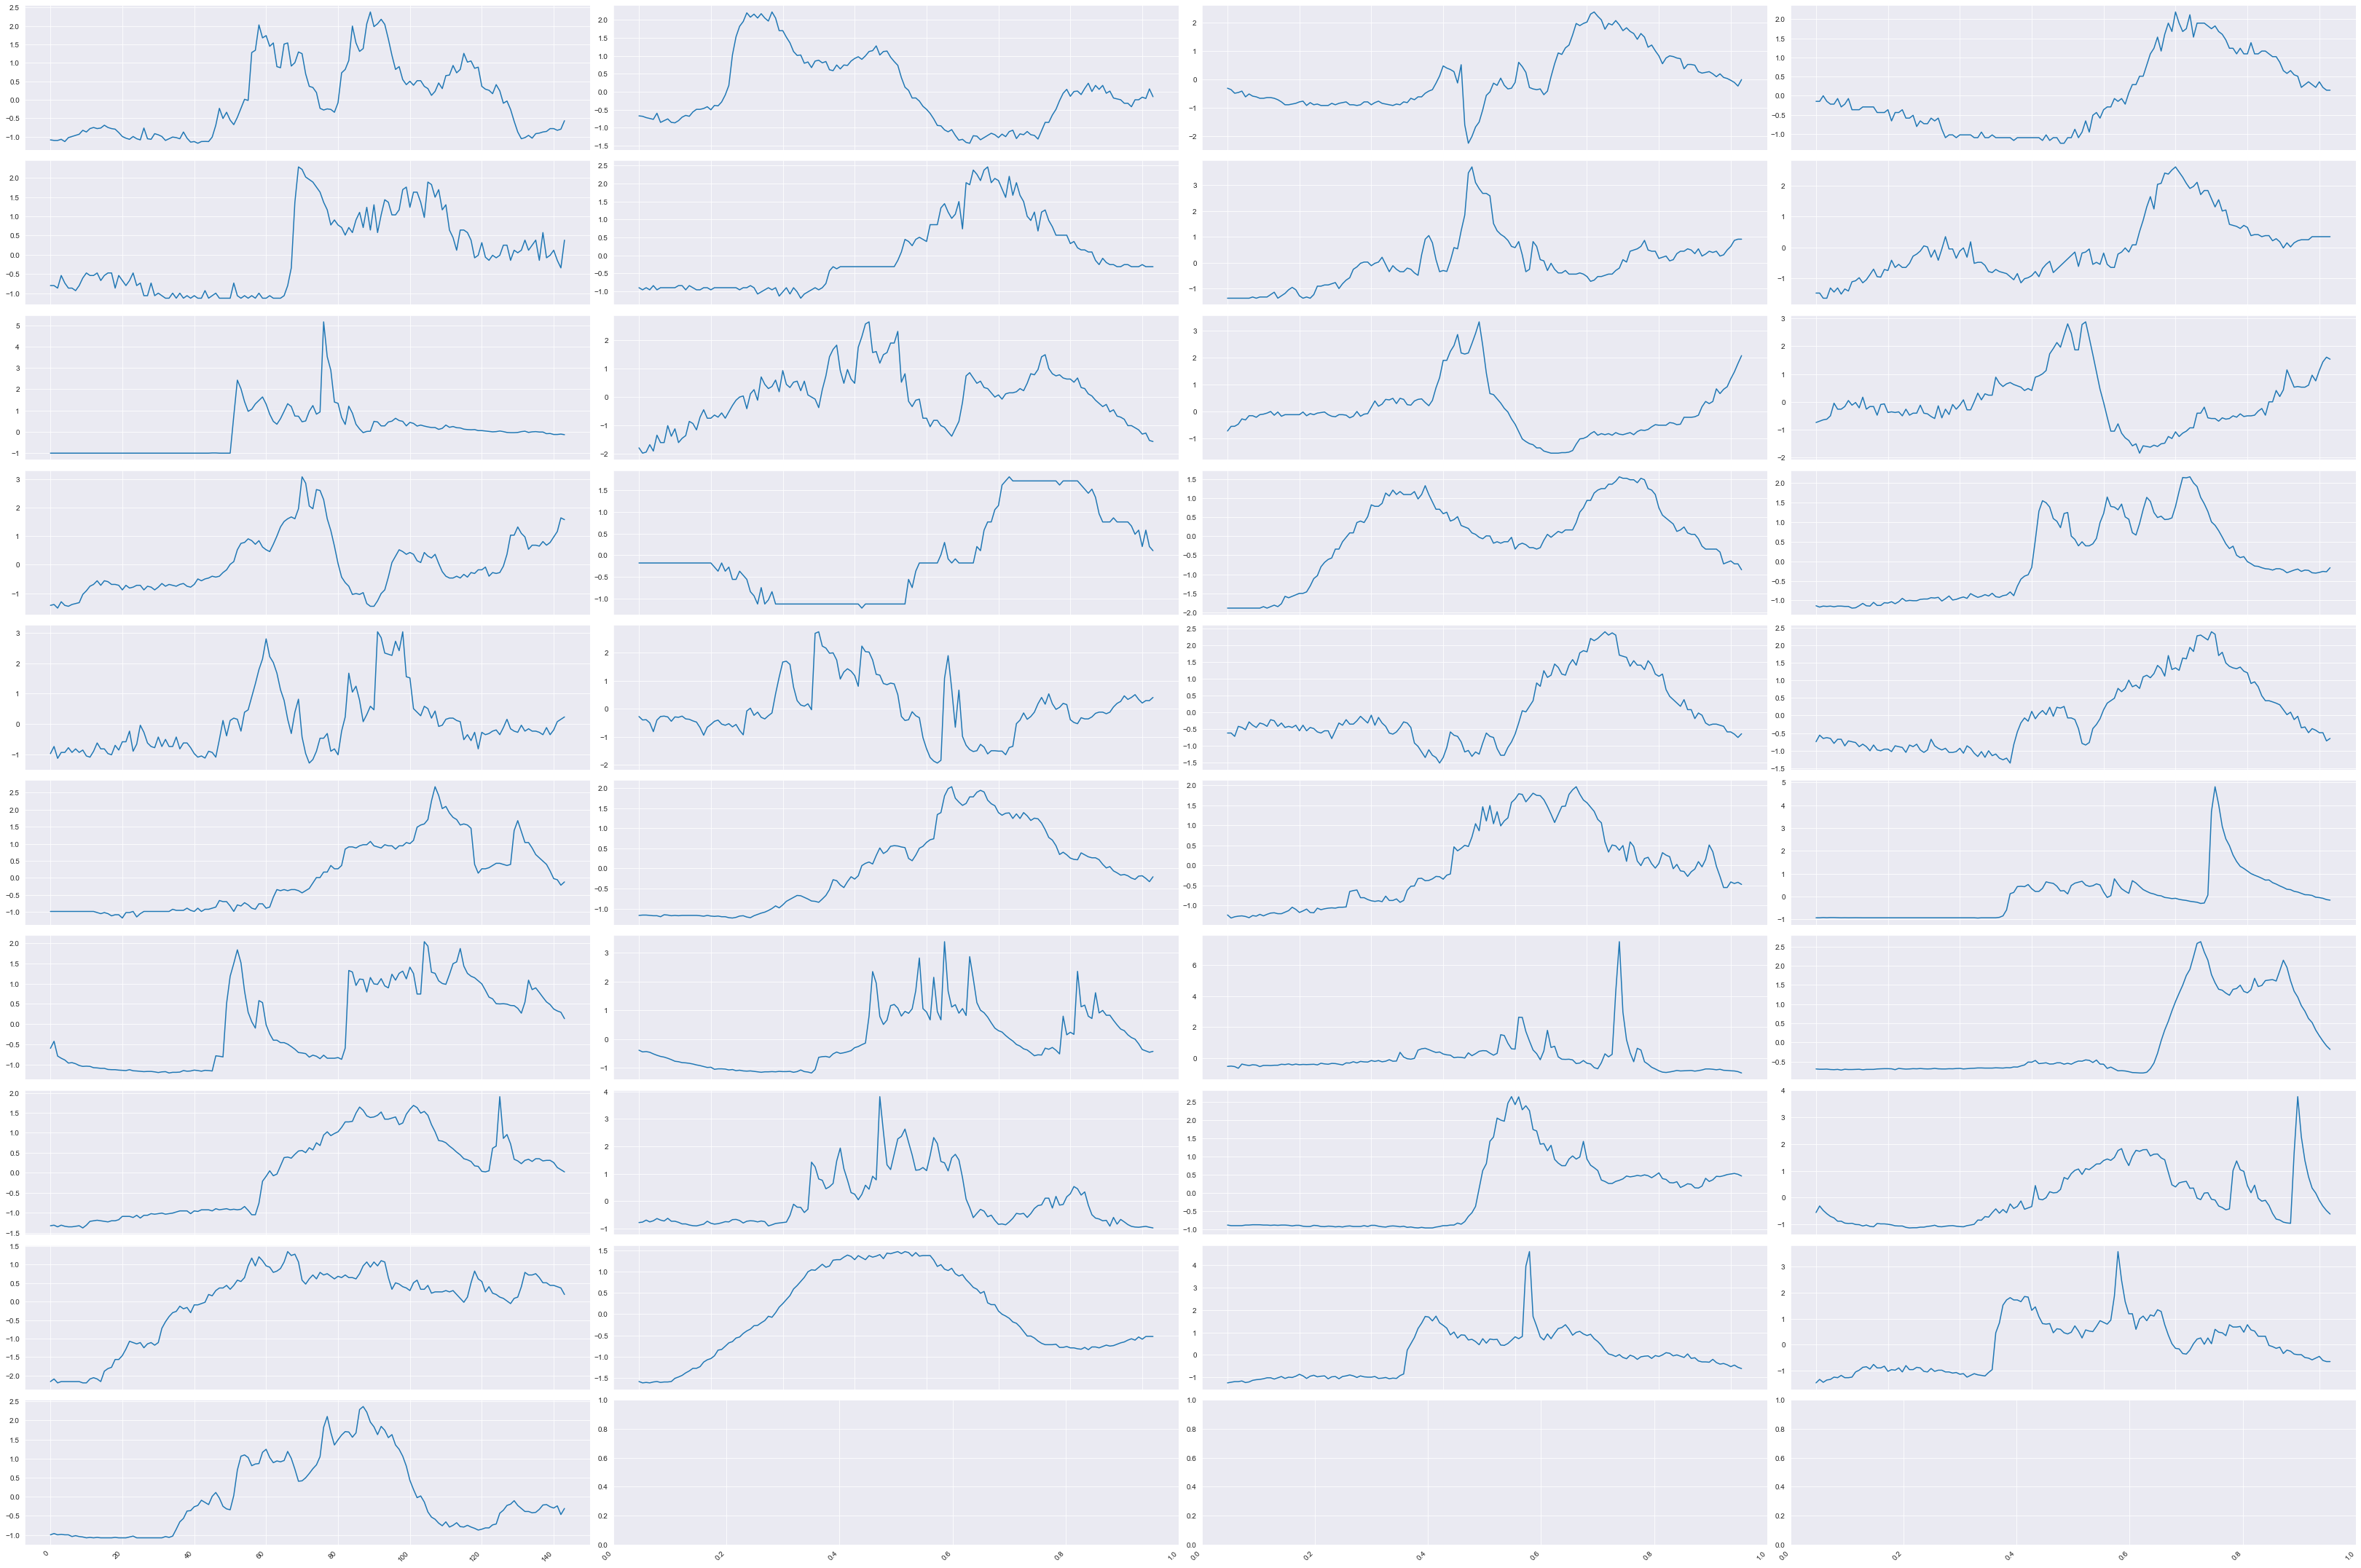

[1, 8, 29, 30, 32, 35, 40, 47, 60, 65, 67, 68, 69, 77, 81, 82, 83, 85, 86, 88, 89, 90, 98, 99, 112, 114, 115, 116, 119, 120, 125, 126, 133, 135, 142, 143, 148]
==========Cluster number: 1==========


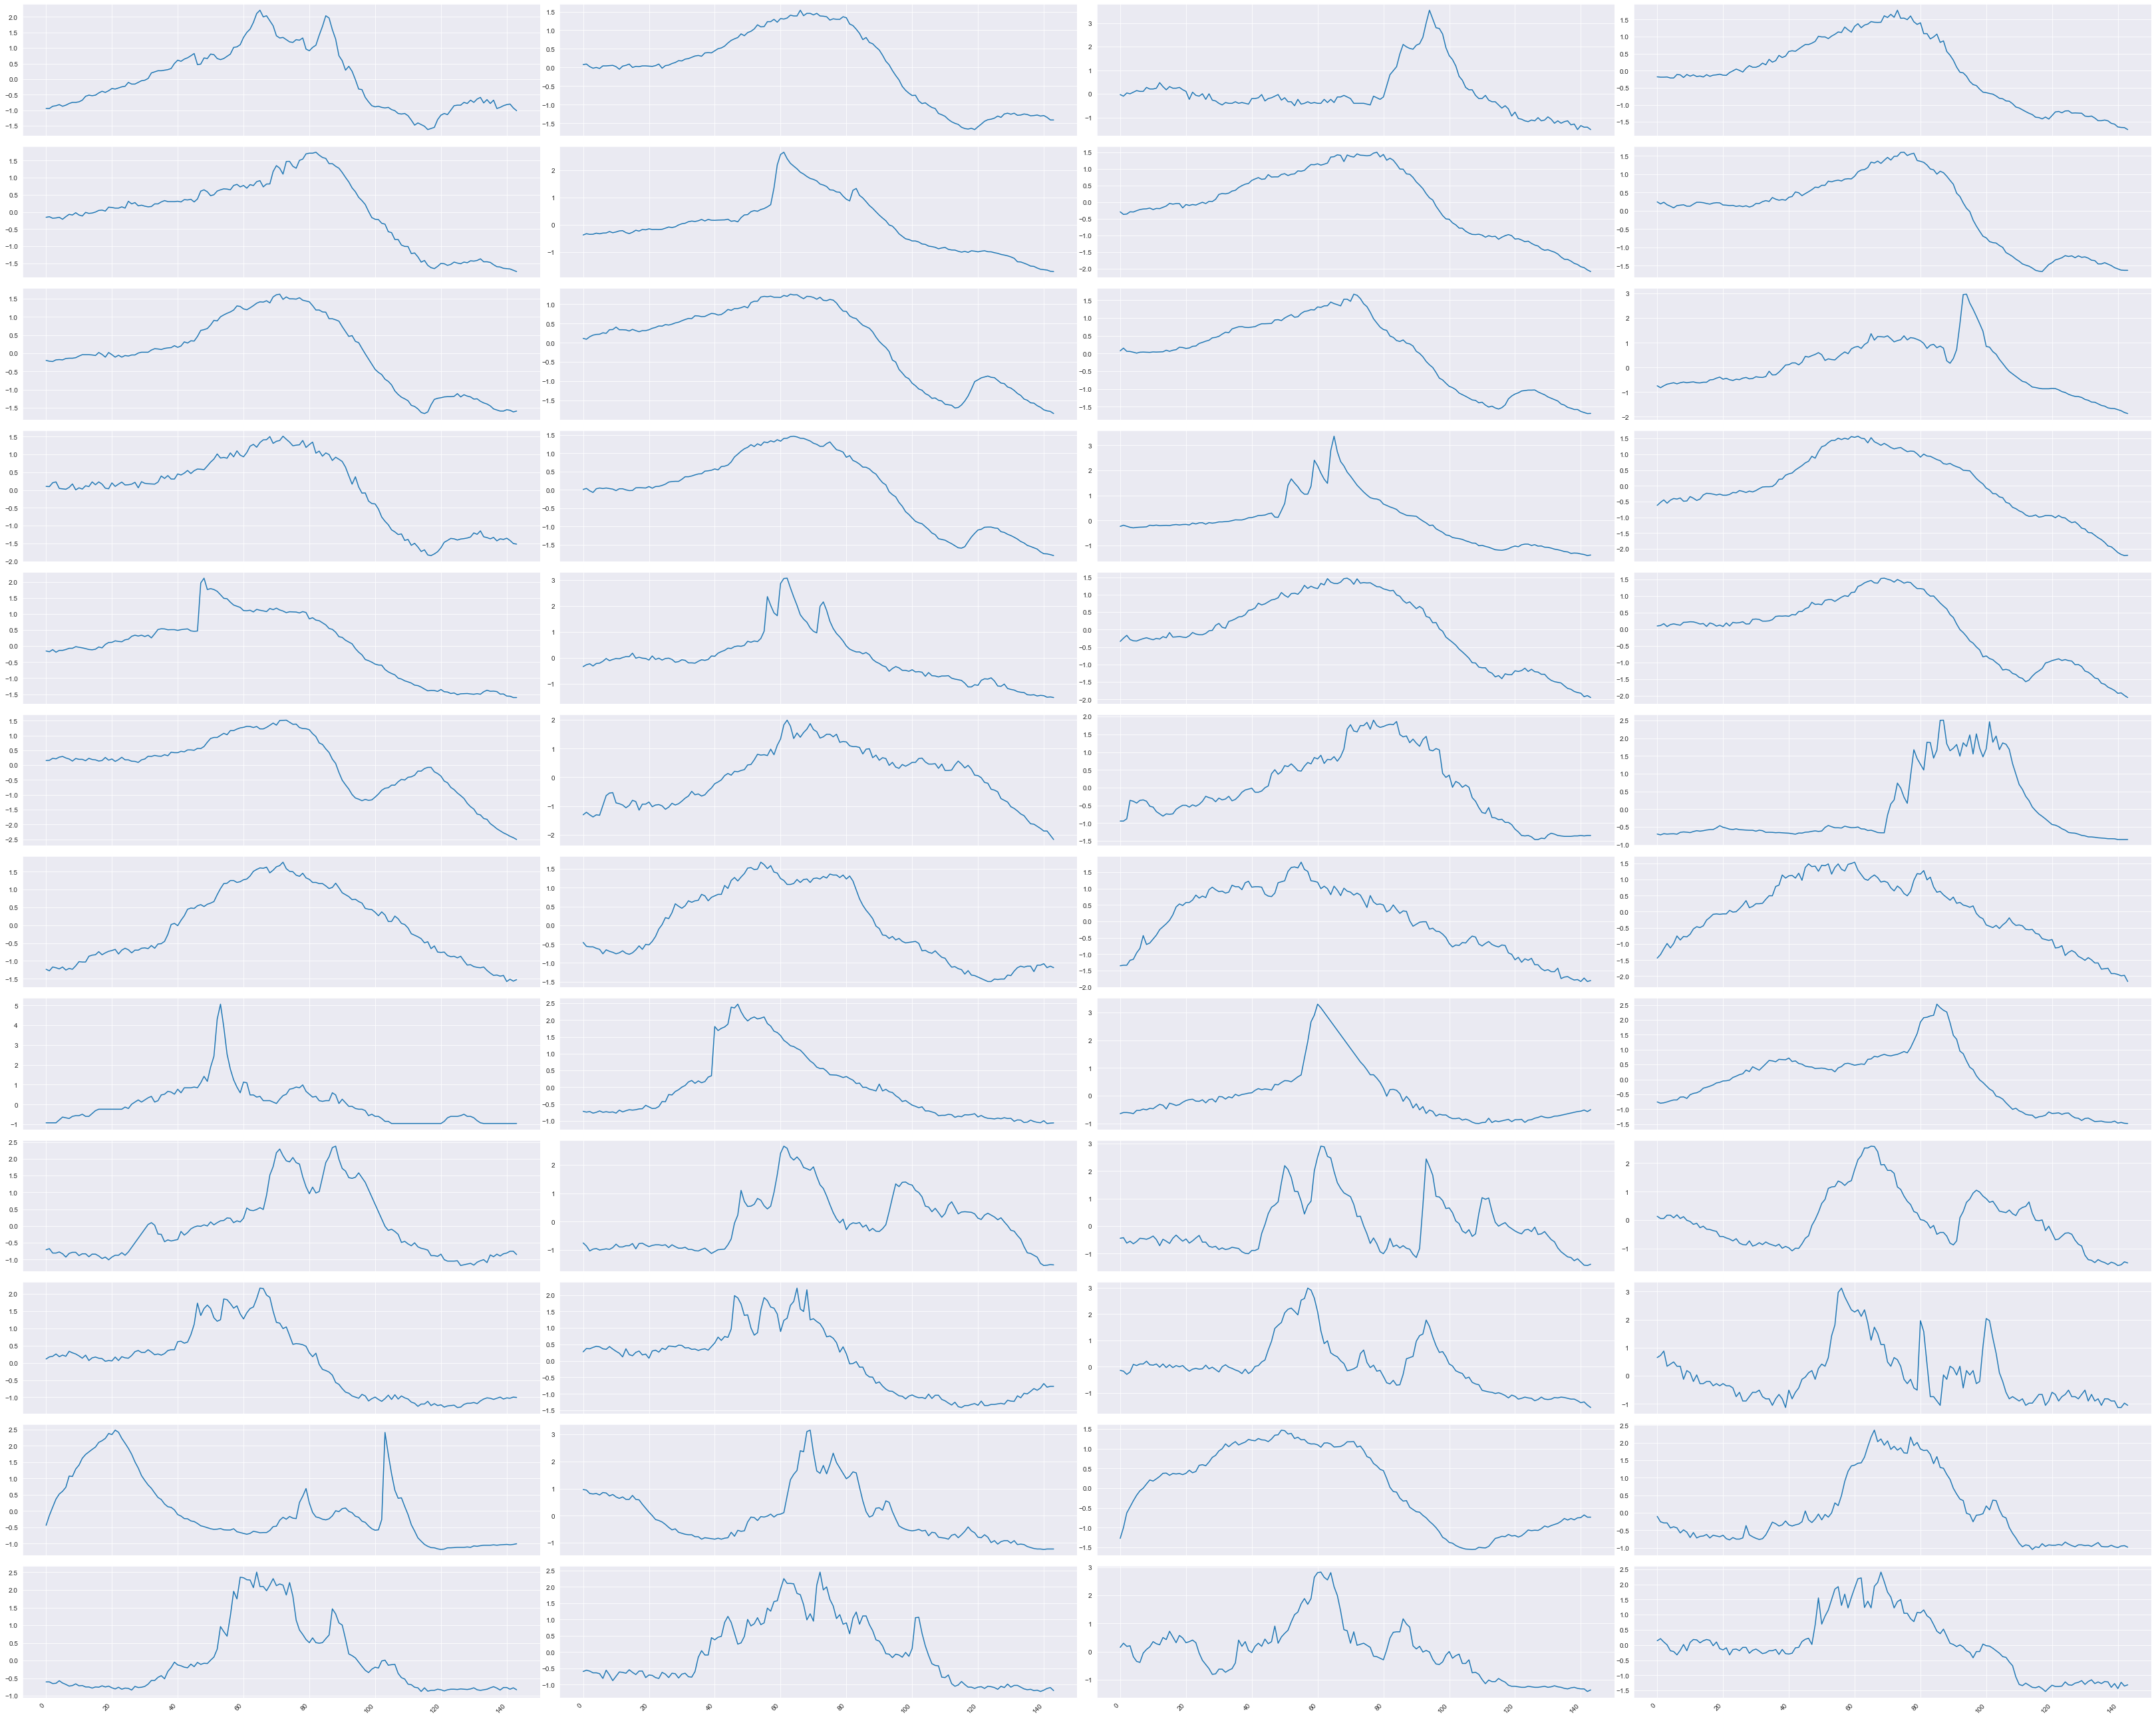

[3, 4, 7, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 33, 36, 37, 38, 41, 42, 43, 44, 48, 52, 53, 70, 71, 72, 73, 74, 75, 76, 95, 106, 134, 145, 146, 147, 149, 150]
==========Cluster number: 2==========


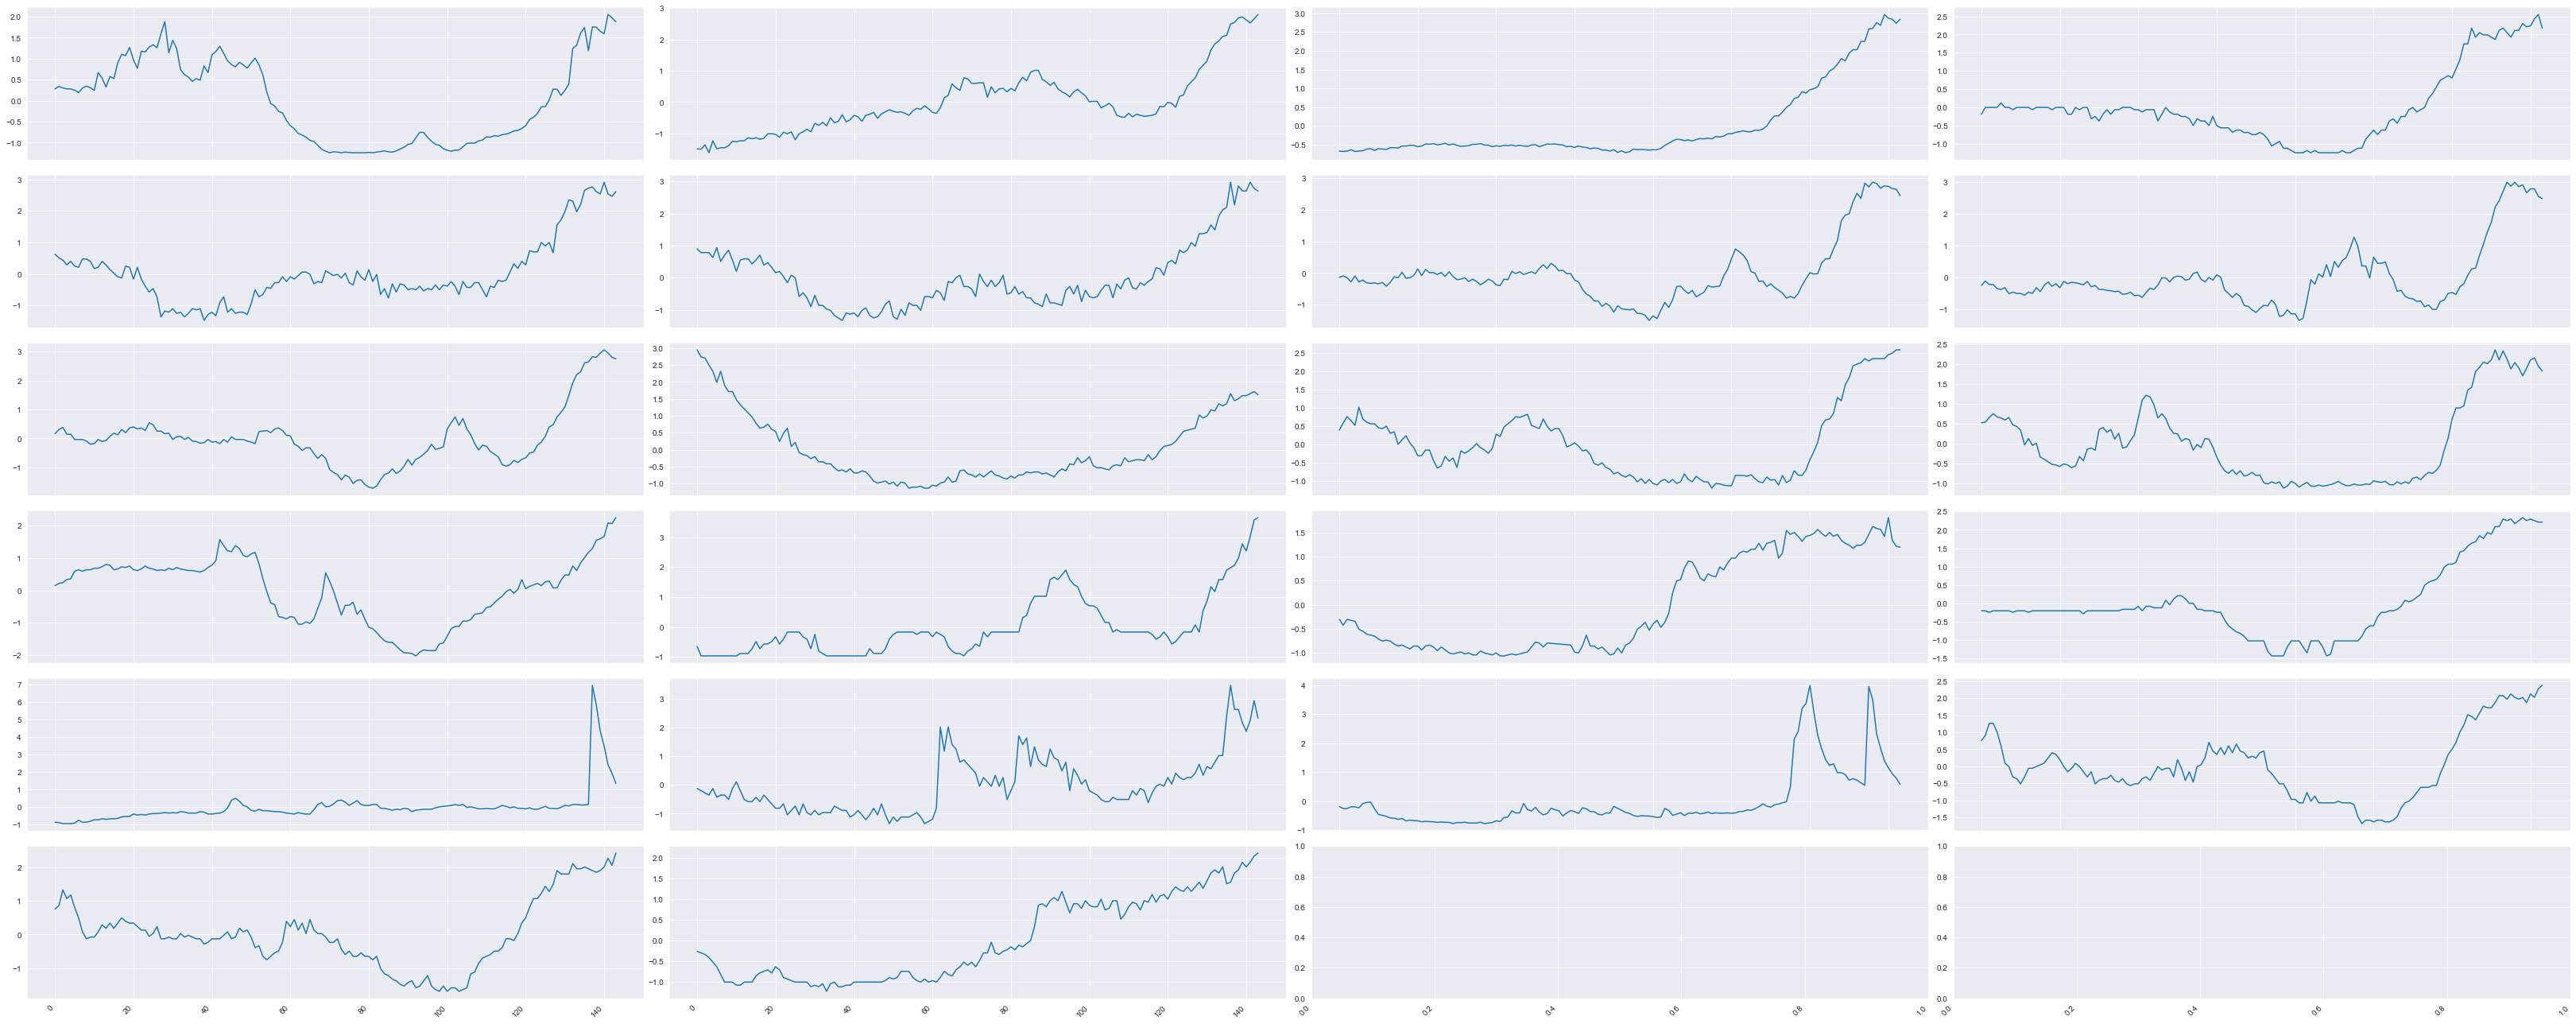

[0, 2, 6, 39, 49, 50, 54, 55, 57, 58, 59, 61, 66, 80, 91, 92, 96, 110, 111, 131, 132, 138]
==========Cluster number: 3==========


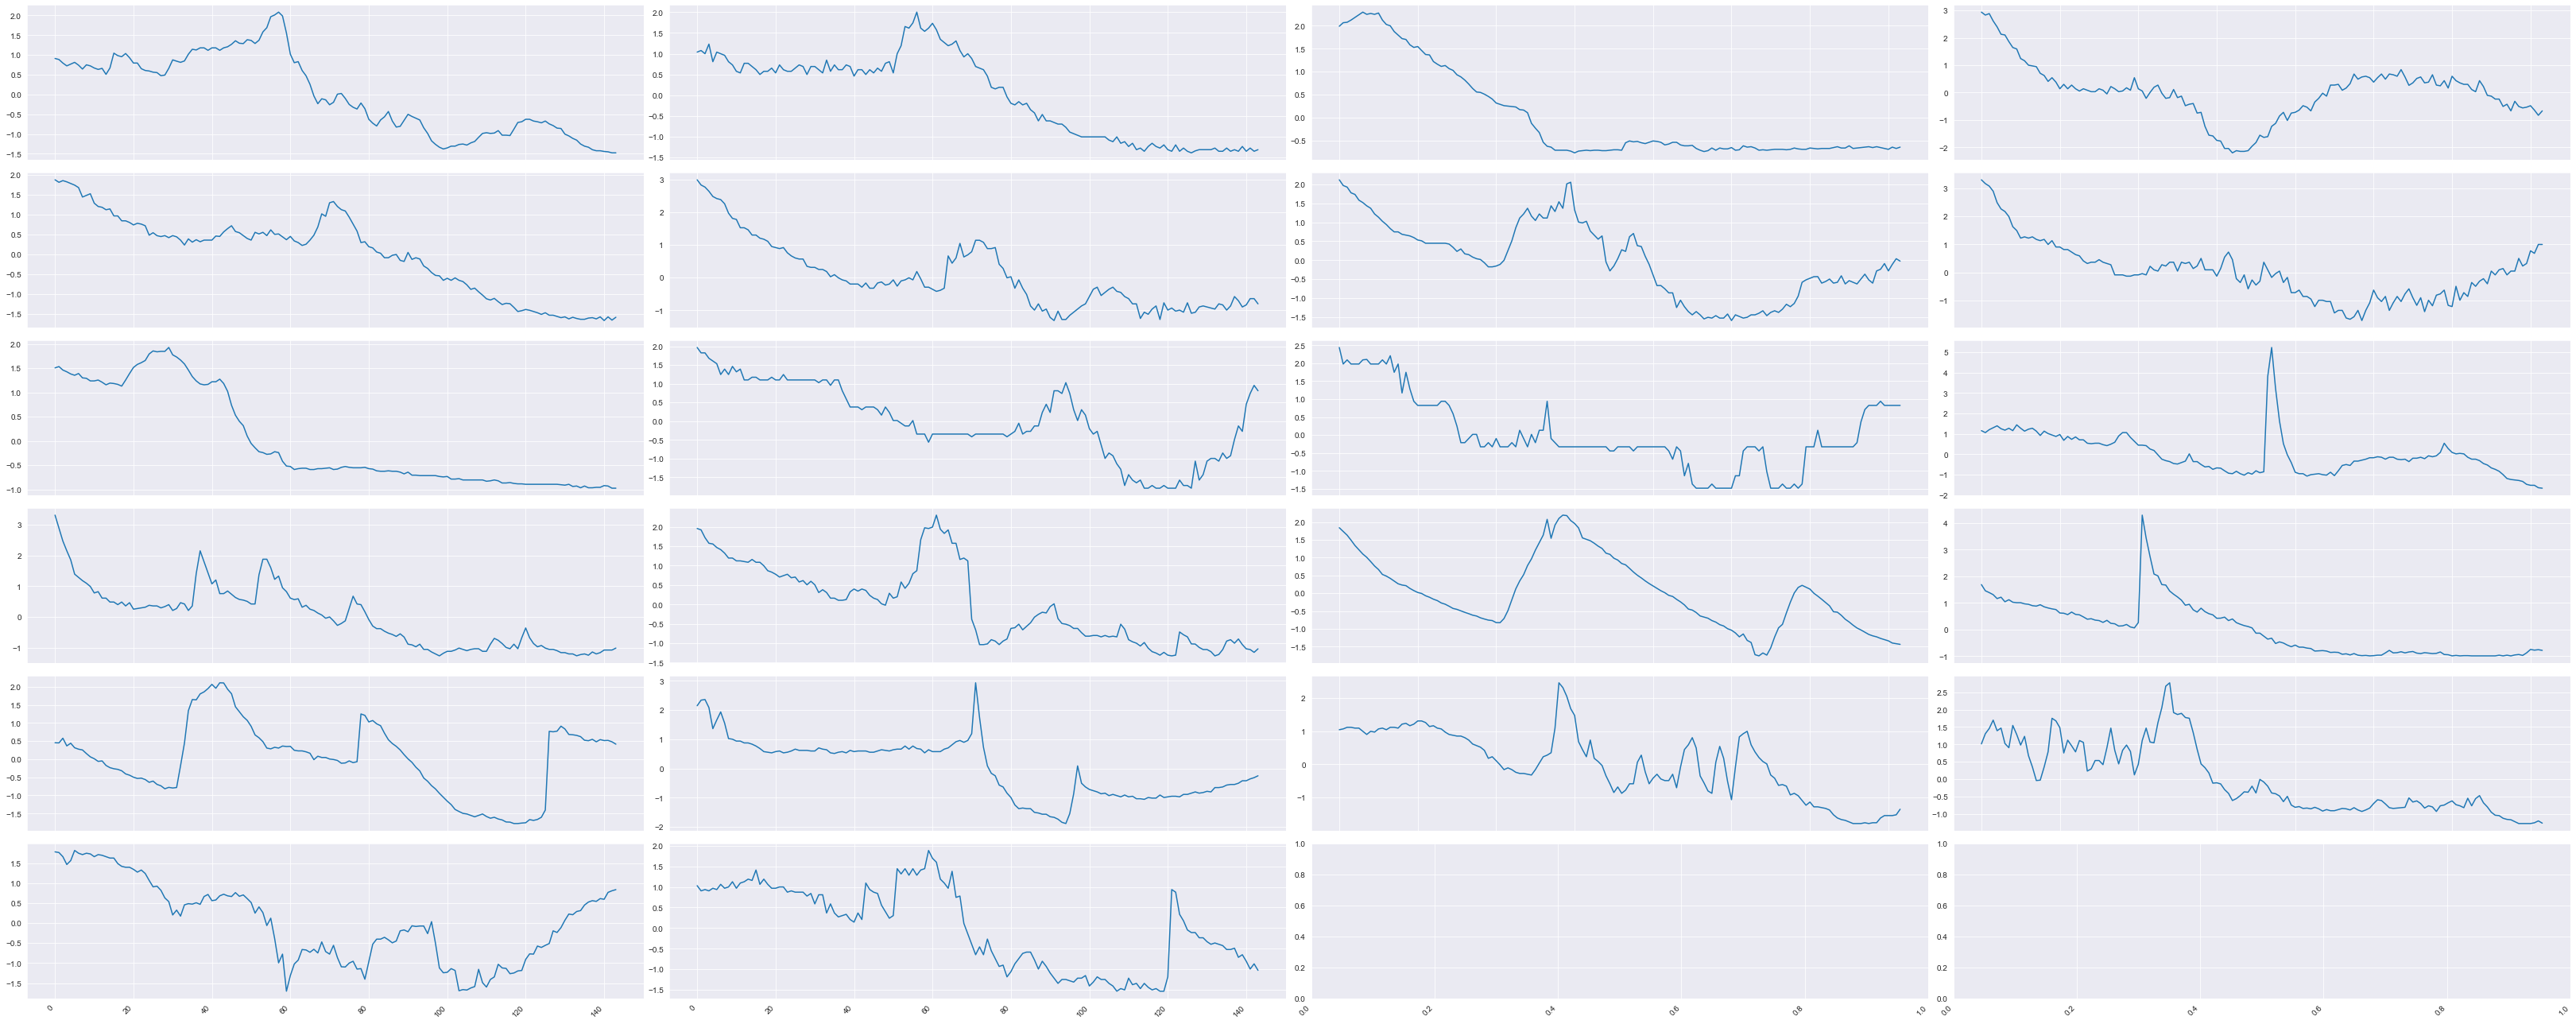

[5, 31, 34, 51, 56, 62, 63, 64, 78, 79, 84, 87, 102, 103, 105, 109, 124, 128, 137, 139, 144, 151]
==========Cluster number: 4==========


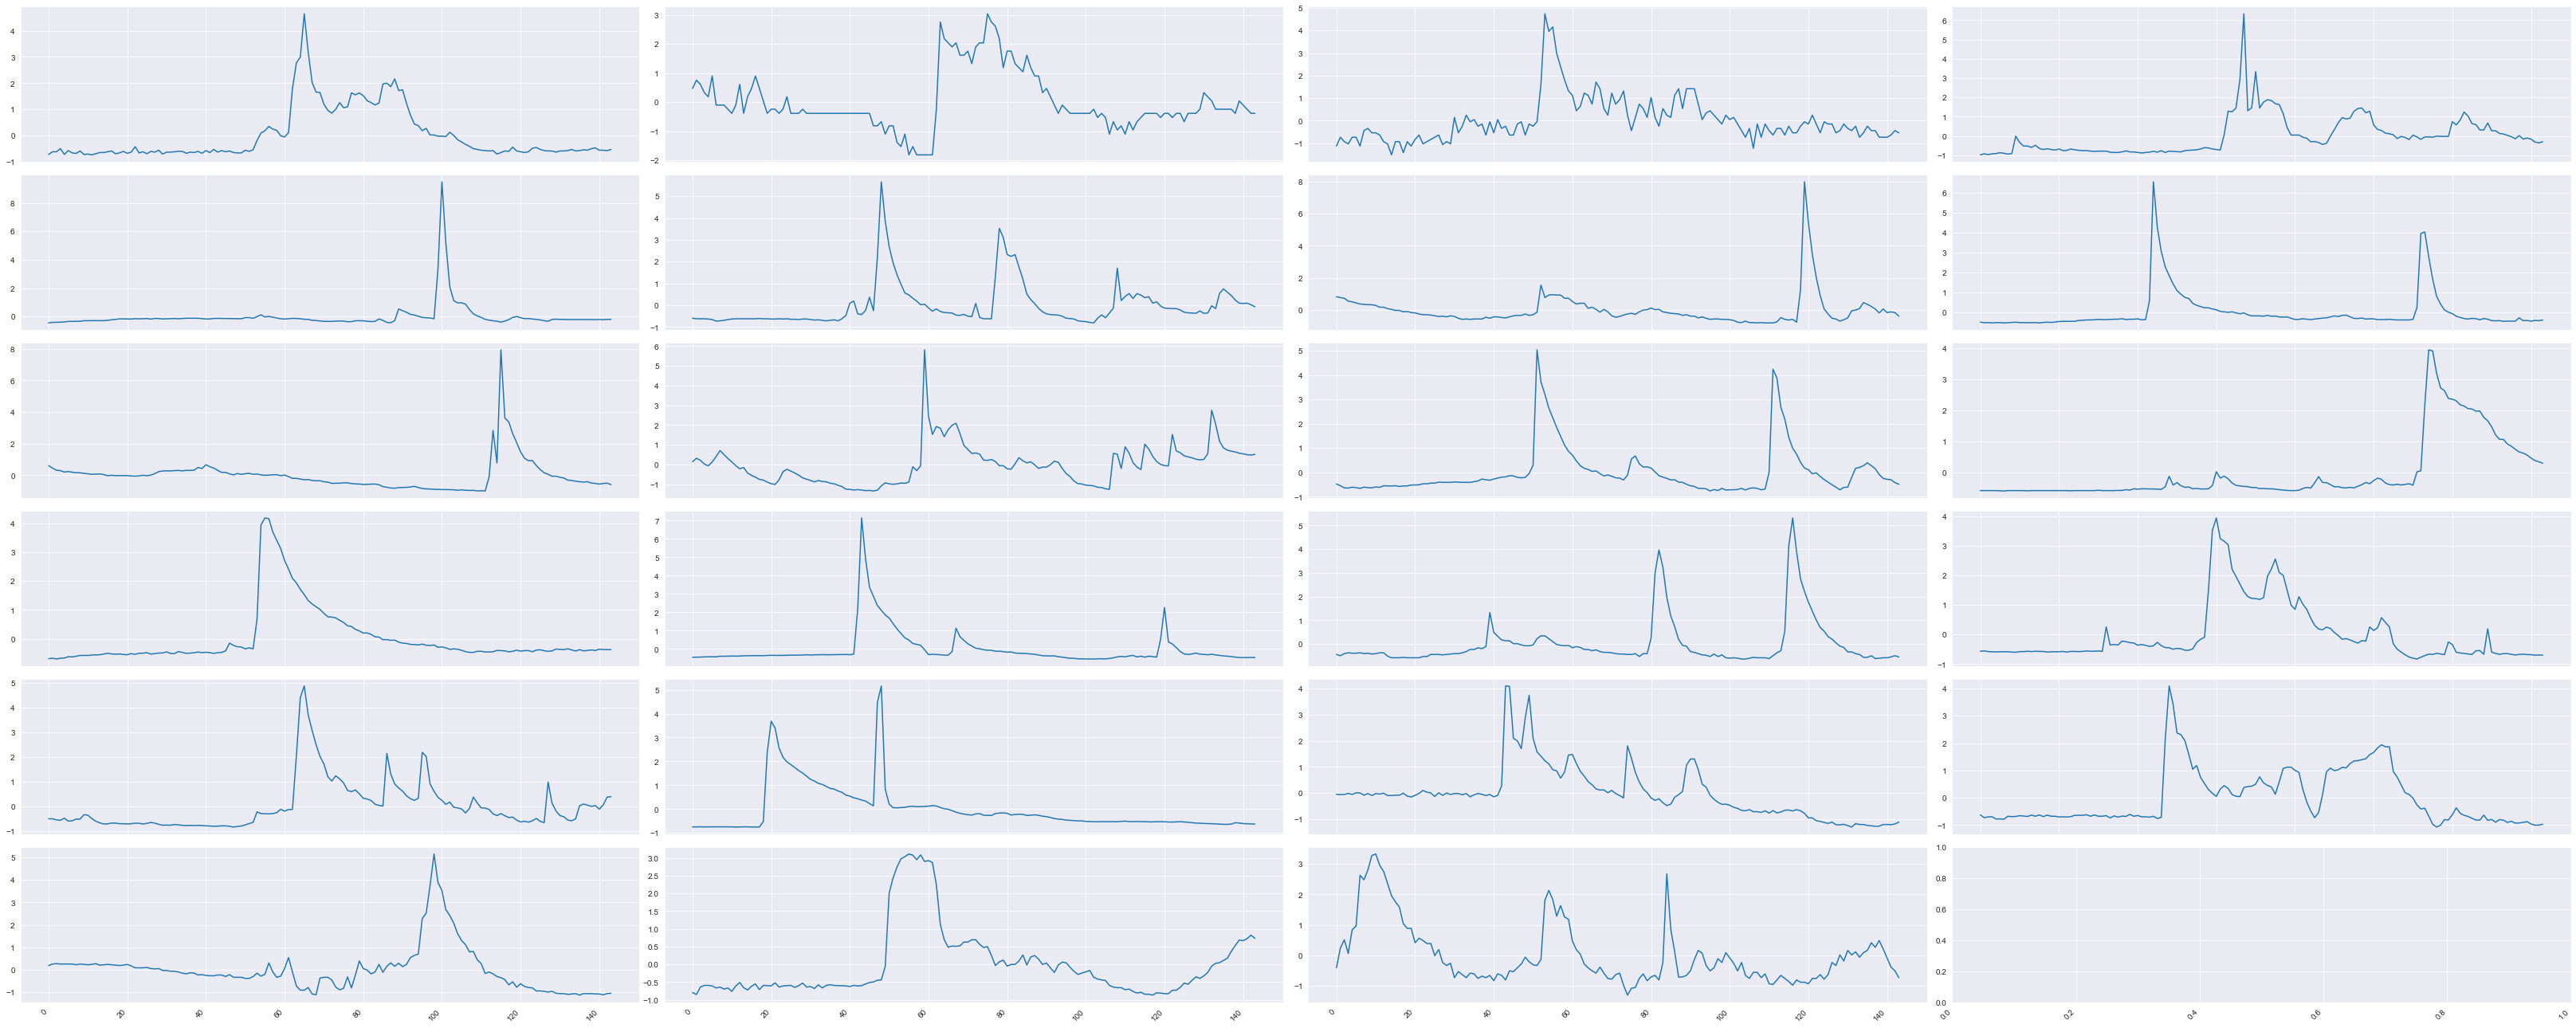

[28, 45, 46, 93, 94, 97, 100, 101, 104, 107, 108, 113, 117, 118, 121, 122, 123, 127, 129, 130, 136, 140, 141]


In [35]:
# 군집별 data sample 형태 조회
for cluster in range(len(ts_clustered)):
    print(f"==========Cluster number: {cluster}==========")
    plot_cluster_ts(ts_clustered[cluster])


In [34]:
def get_DBSCAN_parameter(data, eps_values = np.arange(3,8.75,0.25), min_samples = np.arange(3,10)):
    """
    DBSCAN parameter 탐색 code

    data: pd.DataFrame or np.array
        Time Series Data

    eps_values: np.arange
        eps of DBSCAN
        # eps values to be investigated

    min_samples: np.arange
        min_sample of DBSCAN
        # min_samples values to be investigated
    Returns:
    -------
    None
    """
    DBSCAN_params = list(product(eps_values, min_samples))

    no_of_clusters = []
    sil_score = []
    noise = []
    eps = []
    min_sample = []

    for p in DBSCAN_params:
        DBS_clustering = DBSCAN(eps=p[0], min_samples=p[1]).fit(data)
        clusters = DBS_clustering.labels_
        n_clusters_ = len(set(clusters)) - (1 if -1 in clusters else 0)
        n_noise_ = list(clusters).count(-1)

        if n_clusters_ > 1:
            eps.append(p[0])
            min_sample.append(p[1])
            noise.append(n_noise_)
            no_of_clusters.append(n_clusters_)
            sil_score.append(silhouette_score(data, clusters))


    dict = {'Eps': eps,'Min_samples': min_sample}
    tmp= pd.DataFrame(dict)
    #######################################No_of_clusters############################################################
    tmp['No_of_clusters'] = no_of_clusters
    pivot_1 = pd.pivot_table(tmp, values='No_of_clusters', index='Min_samples', columns='Eps')

    fig, ax = plt.subplots(figsize=(12,6))
    sns.heatmap(pivot_1, annot=True,annot_kws={"size": 16}, cmap="YlGnBu", ax=ax)
    ax.set_title('Number of clusters')
    plt.show()

    ###########################################Sil_score########################################################
    tmp['Sil_score'] = sil_score
    pivot_1 = pd.pivot_table(tmp, values='Sil_score', index='Min_samples', columns='Eps')

    fig, ax = plt.subplots(figsize=(18,6))
    sns.heatmap(pivot_1, annot=True, annot_kws={"size": 10}, cmap="YlGnBu", ax=ax, fmt = '.3f')
    ax.set_title('Sil score')
    plt.show()

    ###########################################Noise########################################################
    tmp['Noise'] = noise
    pivot_1 = pd.pivot_table(tmp, values='Noise', index='Min_samples', columns='Eps')

    fig, ax = plt.subplots(figsize=(18,6))
    sns.heatmap(pivot_1, annot=True, annot_kws={"size": 16}, cmap="YlGnBu", ax=ax, fmt = '.1f')
    ax.set_title('Noise')
    plt.show()



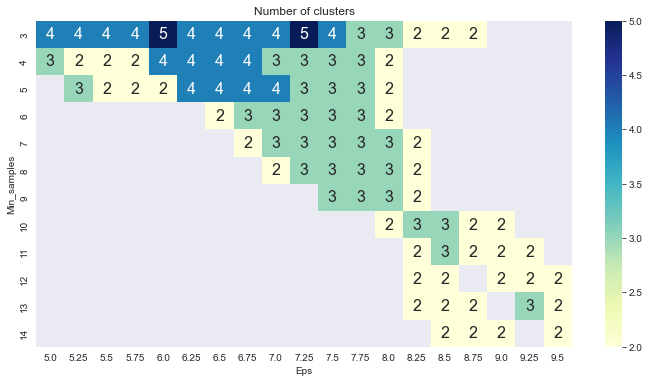

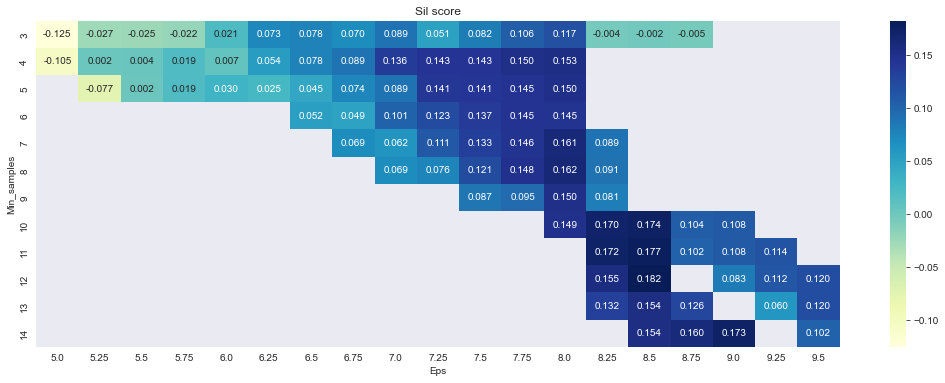

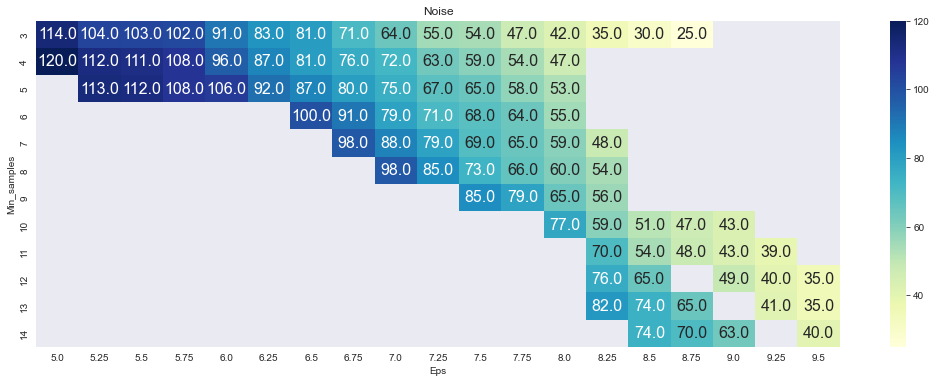

In [35]:
# DBSCAN을 eps_values 범위와 min_samples로 각각 진행하여 클러스터 수와 Sil_score, Noise 결과 시각화
get_DBSCAN_parameter(scaled_ts_df, eps_values = np.arange(5,10,0.25), min_samples = np.arange(3,15))

In [36]:
def get_DBSCAN_results(data, min_samples=10, eps = 0.726):
    """
    파라미터를 지정하여 DBSCAN 결과 생성

    data: pd.DataFrame or np.array
        Time Series Data
    min_samples: int
        # 최소 요소 갯수
    eps: int
        # R와 역할, 반지름 지정

    Returns:
    -------
    None
    """
    # Main metrics

    DBSCAN_model = DBSCAN(eps=eps, min_samples = min_samples)
    DBSCAN_model.fit(data)
    clusters_ss= DBSCAN_model.fit_predict(data)
    clusters = DBSCAN_model.labels_
    n_clusters_ = len(set(clusters)) - (1 if -1 in clusters else 0)
    n_noise_ = list(clusters).count(-1)


    core_samples = np.zeros_like(clusters, dtype=bool)
    core_samples[DBSCAN_model.core_sample_indices_] = True
    #print("Number of core samples:", core_samples)


    print("Number of clusters: %d" % n_clusters_)
    print("Number of noise points: %d" % n_noise_)
    for i in range(n_clusters_):
        print('Cluster', i, ':', len(clusters[clusters==i]))

    print("Silhouette Coefficient: %0.3f" % silhouette_score(data, clusters))



In [37]:
# min_samples=12, eps = 8.5의 DBSCAN 결과
get_DBSCAN_results(data = scaled_ts_df , min_samples=12, eps = 8.5)

Number of clusters: 2
Number of noise points: 65
Cluster 0 : 64
Cluster 1 : 23
Silhouette Coefficient: 0.182


In [41]:
# in_id의 군집결과 조회
cluster_model = DBSCAN(min_samples=12, eps = 8.5)
cluster_labels = cluster_model.fit_predict(scaled_ts_df)
fancy_names_for_labels = [f"Cluster {label}" for label in cluster_labels]
result = pd.DataFrame(zip(namesofMySeries,fancy_names_for_labels),columns=["Series","Cluster"]).sort_values(by="Cluster").set_index("Series")
ts_clustered = [scaled_ts_df.iloc[(cluster_labels == lable), :] for lable in np.unique(cluster_labels)]
result

Cluster
Series                  
ICL1L2000011  Cluster -1
ICW0W2000034  Cluster -1
ICW0W2000033  Cluster -1
ICW0W2000032  Cluster -1
ICW0W2000031  Cluster -1
...                  ...
ICW0W2000816   Cluster 1
ICL1L2000272   Cluster 1
ICW0W2000812   Cluster 1
ICW0W2000789   Cluster 1
ICW0W2000248   Cluster 1

[152 rows x 1 columns]

In [42]:
# 군집별 data sample 수 조회
merge_outer = pd.merge(result,data_cd, how='outer', left_index=True, right_index=True)
result_cnt = merge_outer.groupby('Cluster').count().reset_index()
result_cnt

Cluster  in_serial
0  Cluster -1         65
1   Cluster 0         64
2   Cluster 1         23

## clustering 결과 시각화

==========Cluster number: 0==========


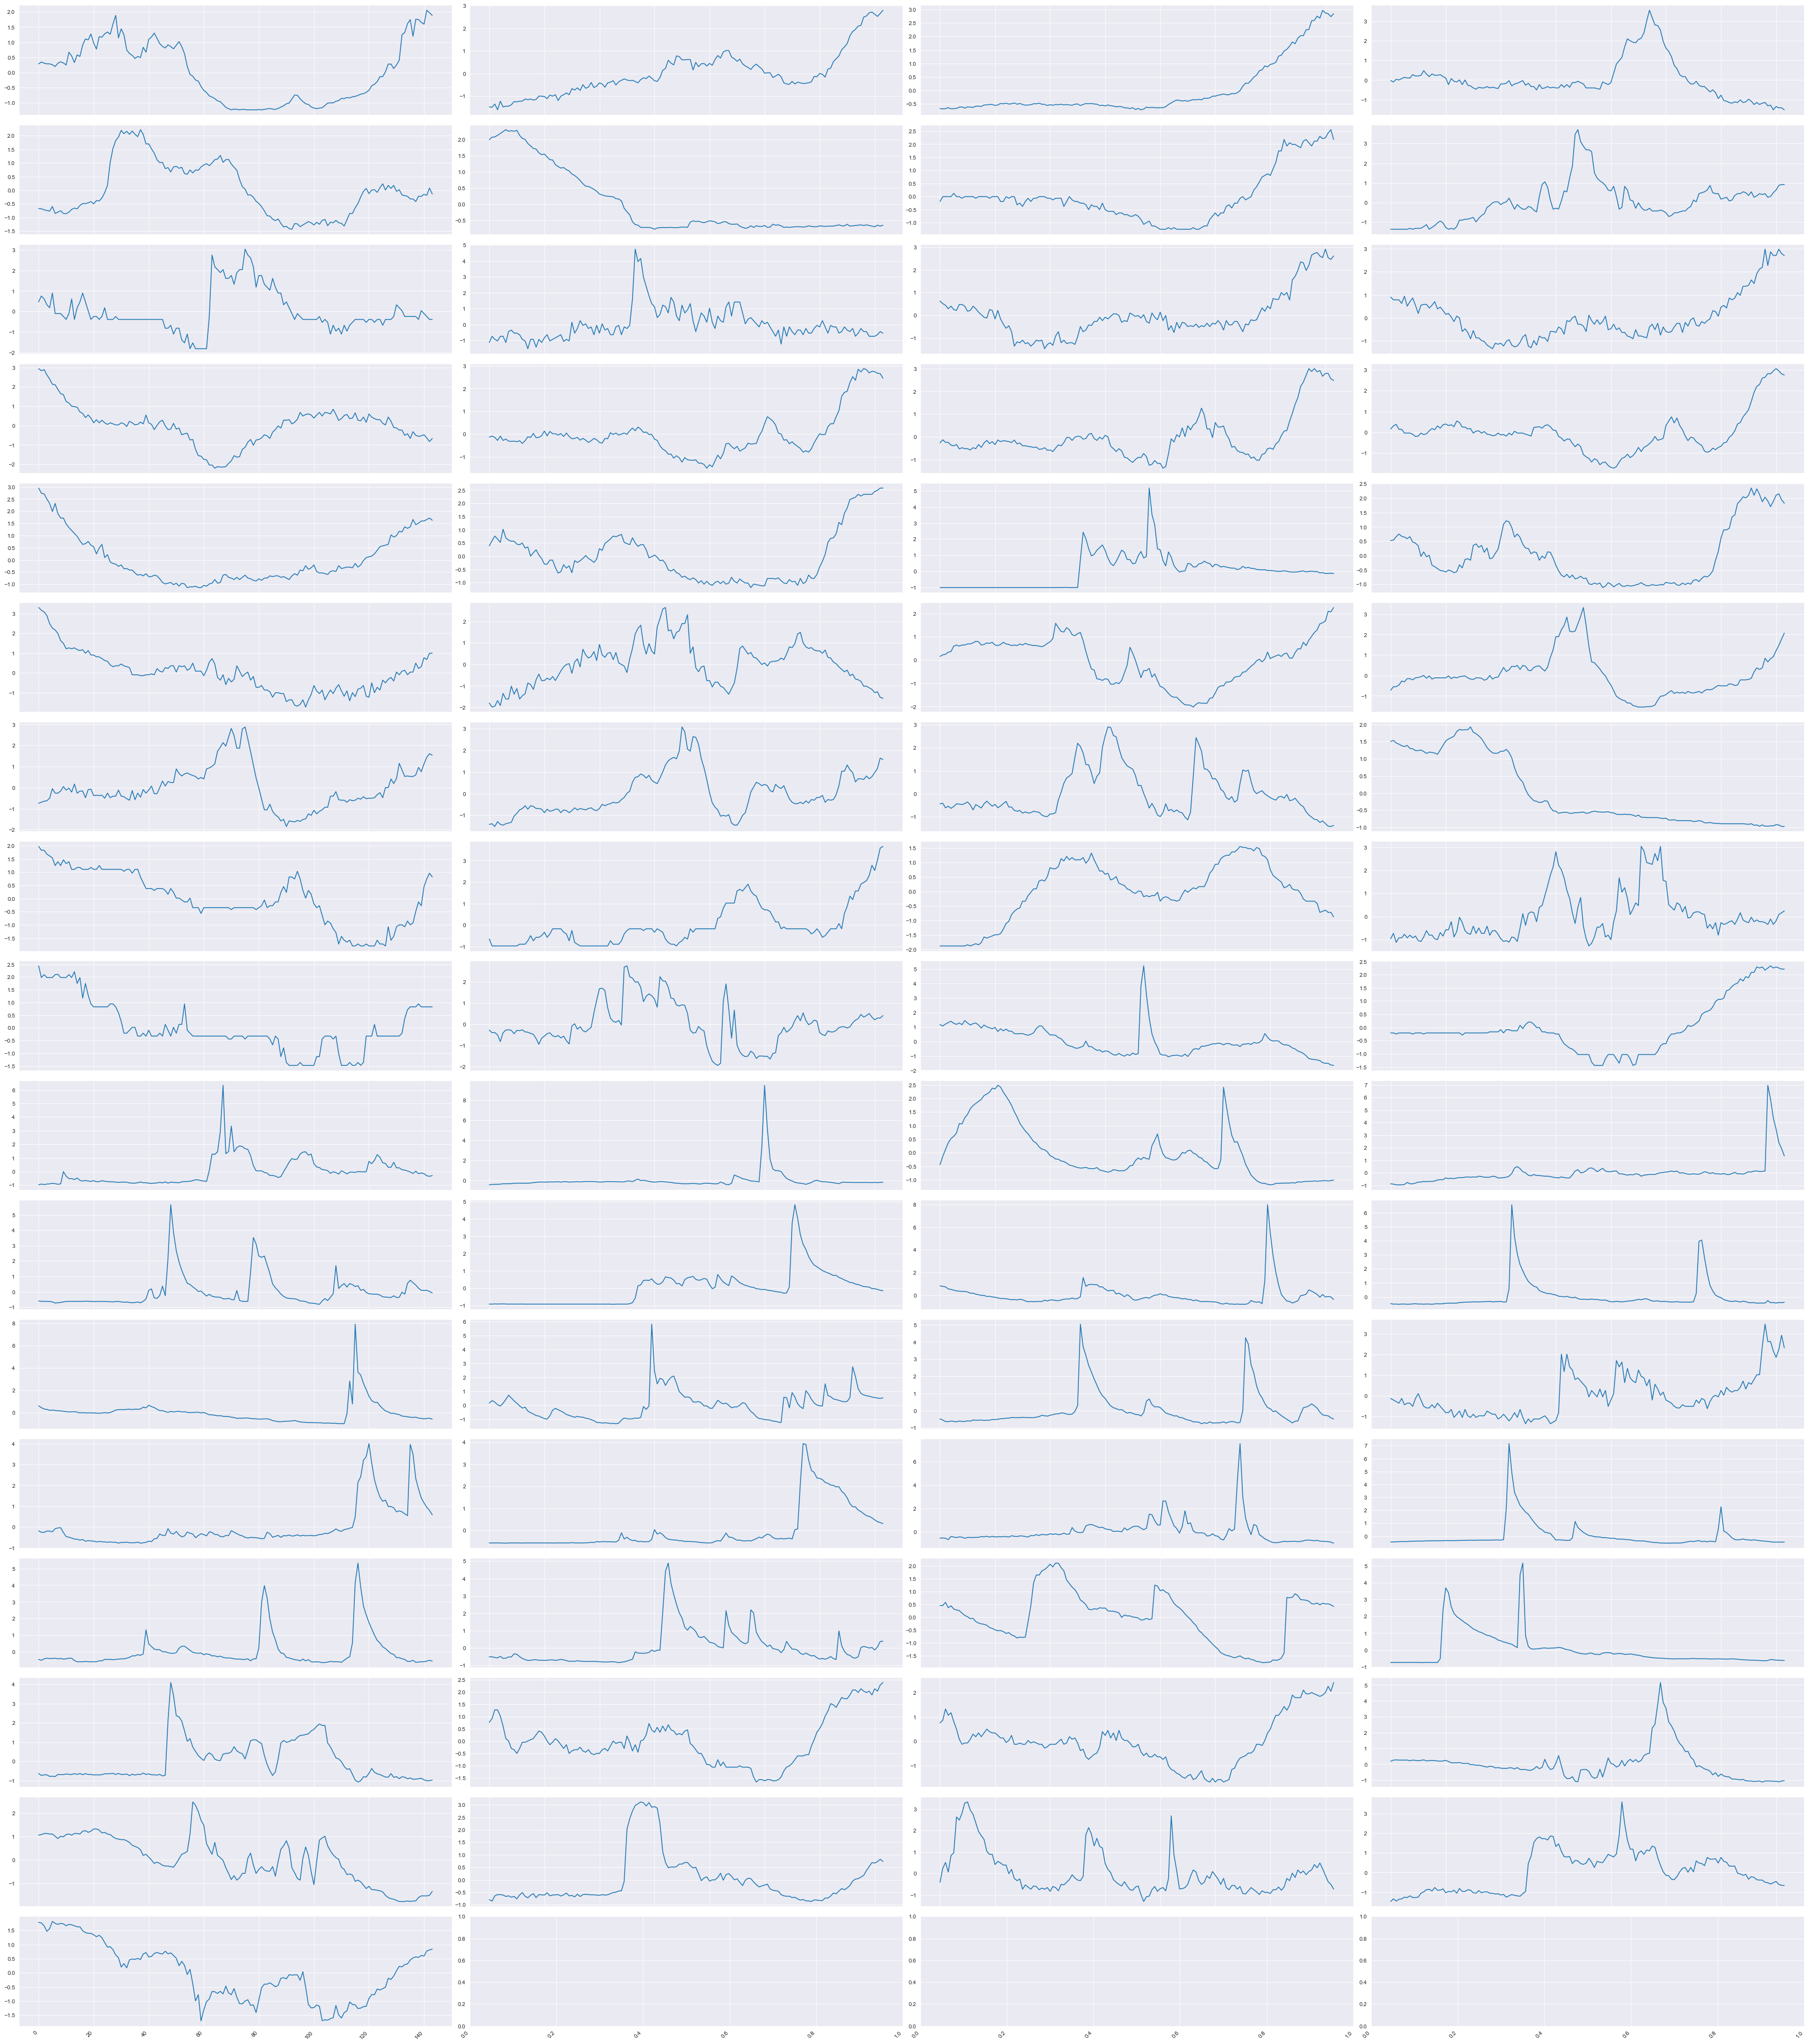

[0, 2, 6, 7, 8, 34, 39, 40, 45, 46, 49, 50, 51, 54, 55, 57, 58, 59, 60, 61, 64, 65, 66, 67, 68, 69, 71, 78, 79, 80, 81, 83, 84, 85, 87, 92, 93, 94, 95, 96, 97, 99, 100, 101, 104, 107, 108, 110, 111, 113, 115, 118, 121, 123, 124, 127, 130, 131, 132, 136, 137, 140, 141, 143, 144]
==========Cluster number: 1==========


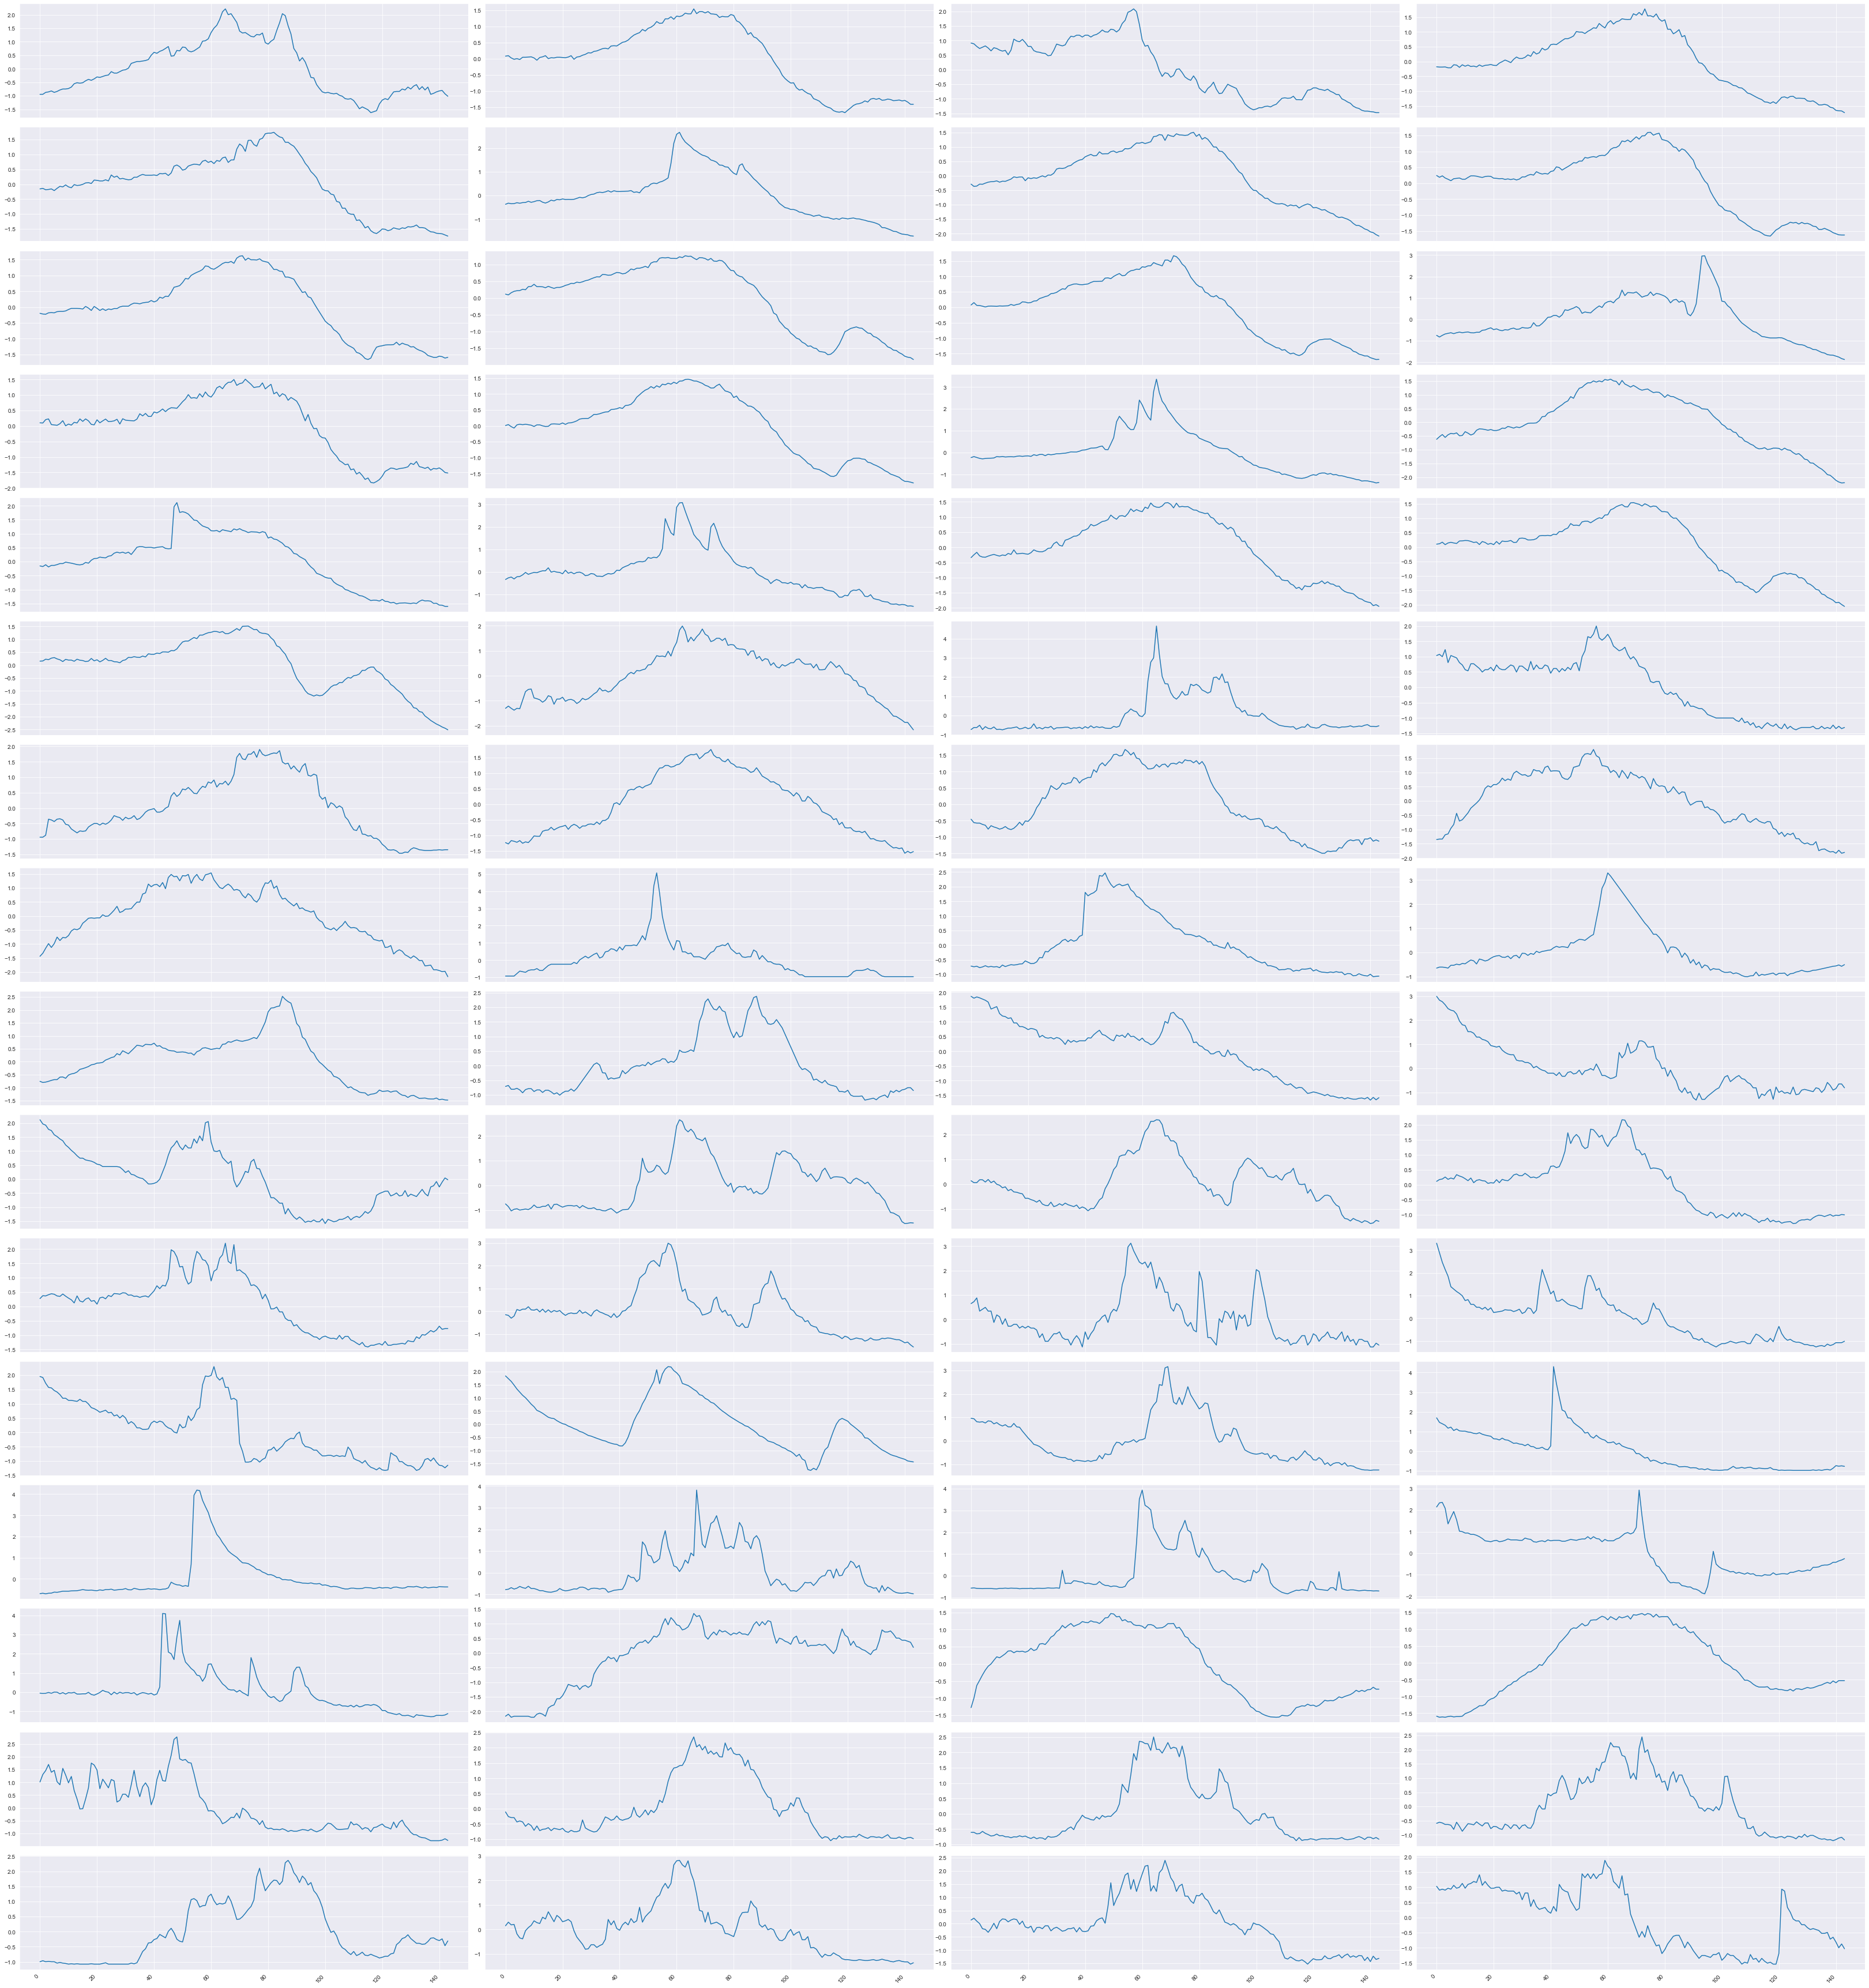

[3, 4, 5, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 31, 33, 37, 38, 41, 42, 43, 44, 48, 52, 53, 56, 62, 63, 70, 72, 73, 74, 75, 76, 102, 103, 105, 106, 109, 117, 120, 122, 128, 129, 133, 134, 135, 139, 145, 146, 147, 148, 149, 150, 151]
==========Cluster number: 2==========


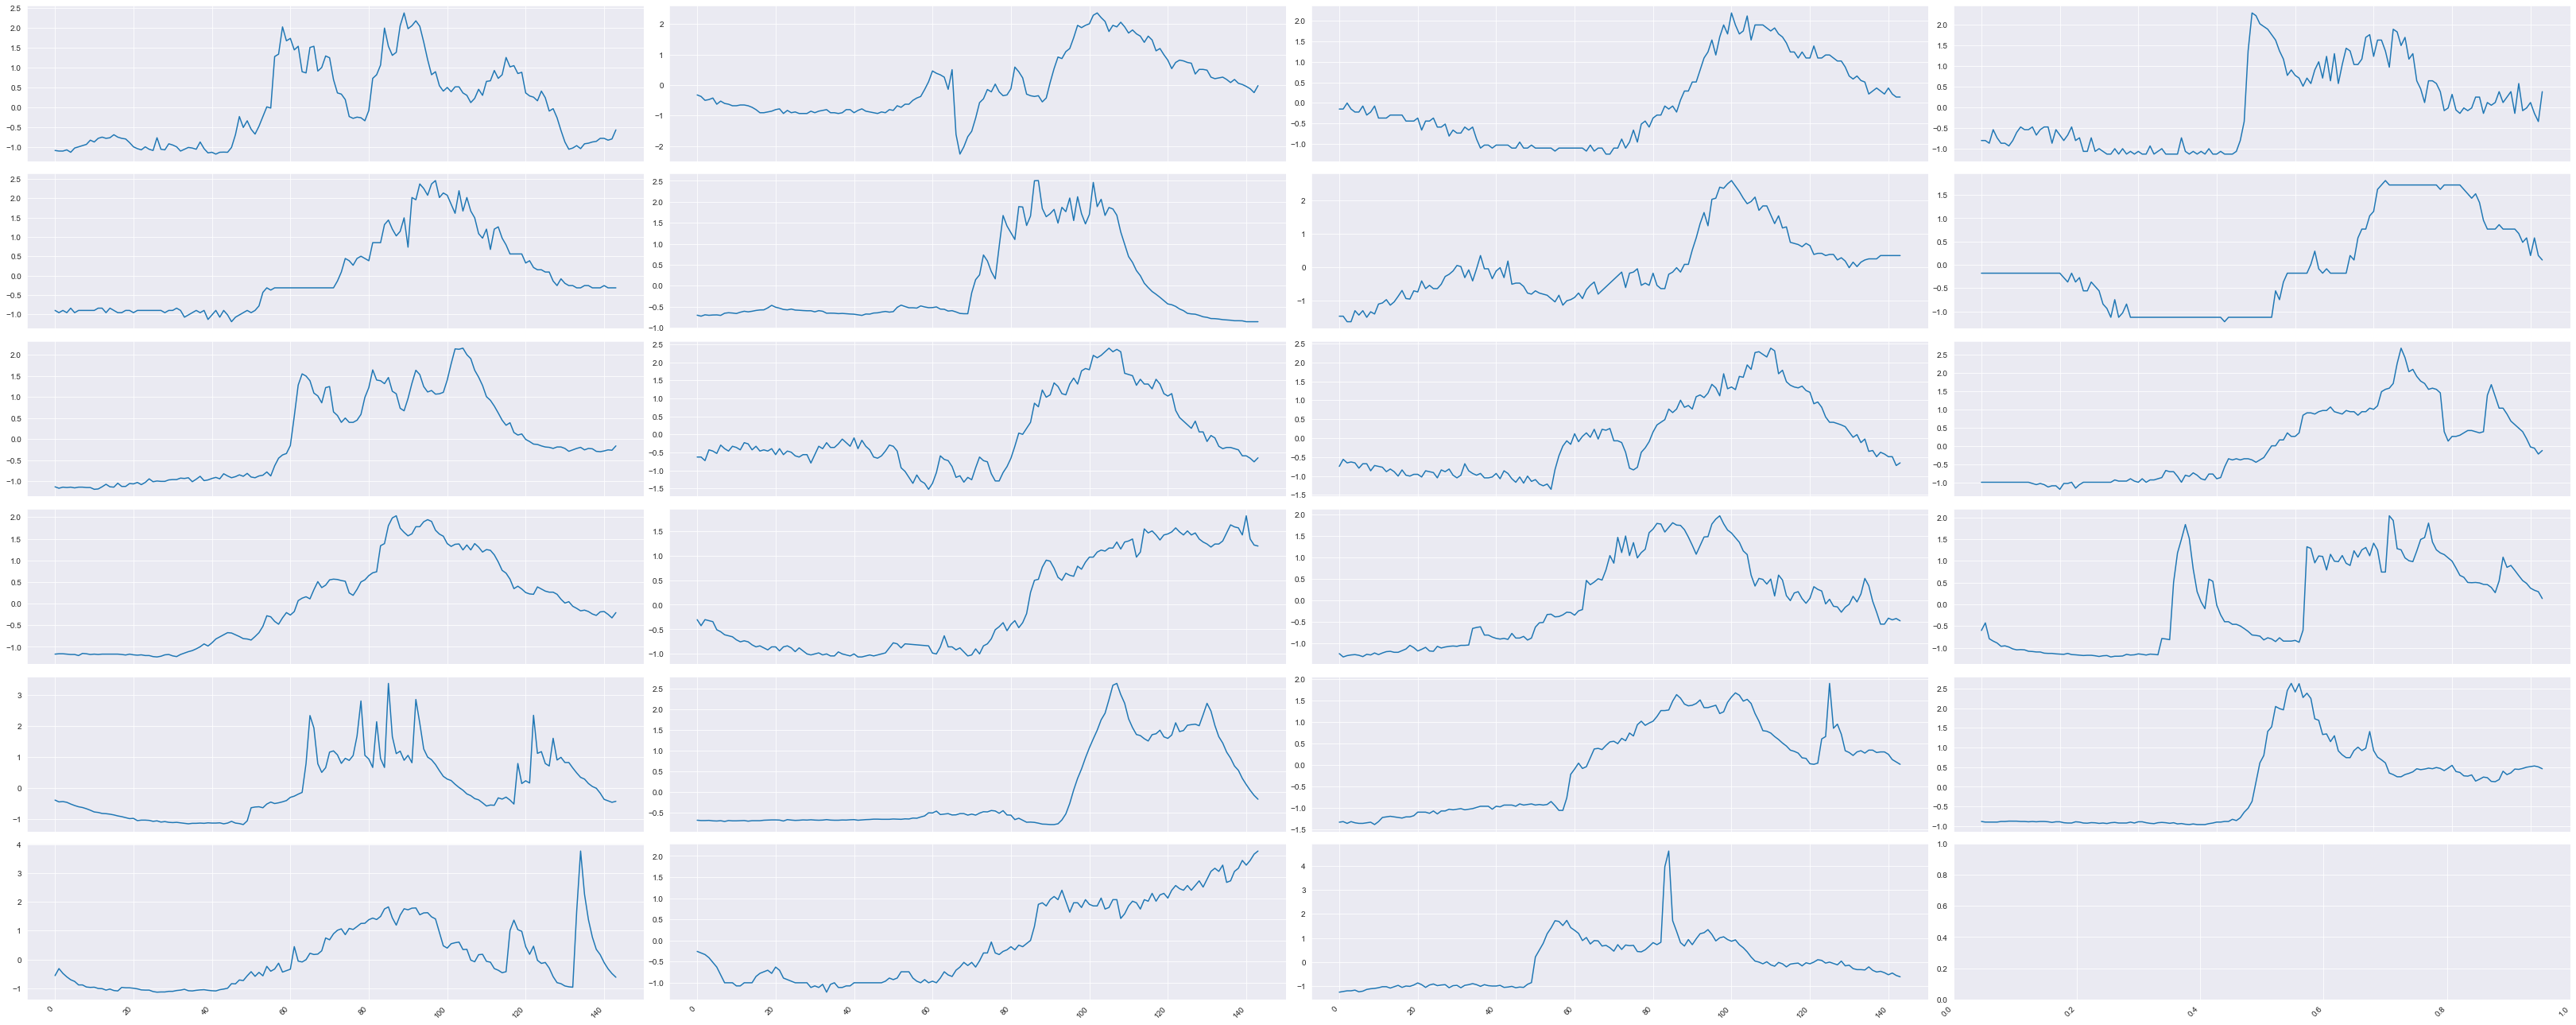

[1, 29, 30, 32, 35, 36, 47, 77, 82, 86, 88, 89, 90, 91, 98, 112, 114, 116, 119, 125, 126, 138, 142]


In [43]:
# cluster_model = DBSCAN(min_samples=12, eps = 8.5)

for cluster in range(len(ts_clustered)):
    print(f"==========Cluster number: {cluster}==========")
    plot_cluster_ts(ts_clustered[cluster])

## clustering 결과 라벨링

In [45]:
pm10_clustering_result= df_pivot_int_test.T.copy()
pm10_clustering_result = pm10_clustering_result.reset_index()

In [49]:
# 클러스터 결과와 input data set을 merge 하여 예측을 위한 data set 생성
result = result.reset_index()
test = pd.merge(pm10_clustering_result,result, how='left', left_on='in_id', right_on='Series')

In [52]:
PM10_clustering_result = test.drop(["Series"], axis=1)

In [53]:
PM10_clustering_result.head()

in_id     0     1     2     3     4     5     6          7     8  \
0  ICL1L2000011  21.5  22.3  21.8  21.5  21.5  21.1  20.3  21.777778  22.4   
1  ICL1L2000017  11.4  11.3  11.3  11.5  11.1  11.8  12.0  12.200000  12.4   
2  ICL1L2000064  15.3  15.2  16.1  14.5  16.9  15.3  15.5  15.500000  15.9   
3  ICL1L2000065  16.2  16.2  16.6  16.7  16.9  16.6  16.8  17.100000  17.3   
4  ICL1L2000234  43.3  43.5  42.5  41.9  42.2  41.8  42.8  42.800000  42.9   

   ...   135   136   137   138   139   140   141   142   143     Cluster  
0  ...  41.2  33.8  41.4  41.3  40.0  39.2  45.4  44.3  43.1  Cluster -1  
1  ...  12.5  12.6  12.8  12.9  13.4  13.4  13.1  13.3  14.8   Cluster 1  
2  ...  38.0  40.3  40.6  41.5  41.7  41.1  40.5  41.3  42.2  Cluster -1  
3  ...  17.1  17.7  16.2  16.4  16.7  16.9  17.0  16.3  15.8   Cluster 0  
4  ...  24.1  23.6  23.7  23.9  23.5  23.7  23.0  22.0  22.0   Cluster 0  

[5 rows x 146 columns]

In [74]:
# 클러스터링 결과 csv 저장
address = 'data_processing/Dataset'
test.to_csv(os.path.join(address,'PM10_clustering_1day_result.csv'), encoding="cp949", index=False)